<a href="https://colab.research.google.com/github/MatthewSebastian15/Automated-Portfolio-Management/blob/main/10_Indonesian_Blue_Chip/Main_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated Portfolio Management**
## **(ADRO, AMMN, ASII, BBCA, BMRI, BBNI, BBRI, ICBP, MDKA, TLKM)**

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from scipy.optimize import minimize
from datetime import datetime, timedelta

In [2]:
TICKERS = [
    'ADRO.JK',  # PT Adaro Energy Indonesia Tbk
    'AMRT.JK',  # PT Sumber Alfaria Trijaya Tbk
    'ASII.JK',  # PT Astra International Tbk
    'BBCA.JK',  # PT Bank Central Asia Tbk
    'BBNI.JK',  # PT Bank Negara Indonesia (Persero) Tbk
    'BBRI.JK',  # PT Bank Rakyat Indonesia (Persero) Tbk
    'BMRI.JK',  # PT Bank Mandiri (Persero) Tbk
    'ICBP.JK',  # PT Indofood CBP Sukses Makmur Tbk
    'ISAT.JK',  # PT Indosat Ooredoo Hutchison Tbk
    'MDKA.JK',  # PT Merdeka Copper Gold Tbk
    'MYOR.JK',  # PT Mayora Indah Tbk
    'TLKM.JK'   # PT Telkom Indonesia (Persero) Tbk
]

START_DATE = '2006-01-01'
END_DATE = '2025-12-31'
TOP_N = 5
LOOKBACK_WINDOW = 60
FORWARD_DAYS = 5
ROLLING_SCALER_DAYS = 756
MV_LOOKBACK_DAYS = 756
REBALANCE_FREQ = 'ME'

In [3]:
# LOAD DATA
def load_data(tickers, start, end):
    raw_data = yf.download(tickers, start=start, end=end, auto_adjust=True)
    prices = raw_data['Close'].ffill().bfill()
    volumes = raw_data['Volume'].ffill().bfill()
    log_returns = np.log(prices / prices.shift(1))
    log_returns = log_returns.replace([np.inf, -np.inf], np.nan).dropna()
    valid_idx = log_returns.index
    return prices.loc[valid_idx], volumes.loc[valid_idx], log_returns

prices, volumes, log_returns = load_data(TICKERS, START_DATE, END_DATE)

[*********************100%***********************]  12 of 12 completed


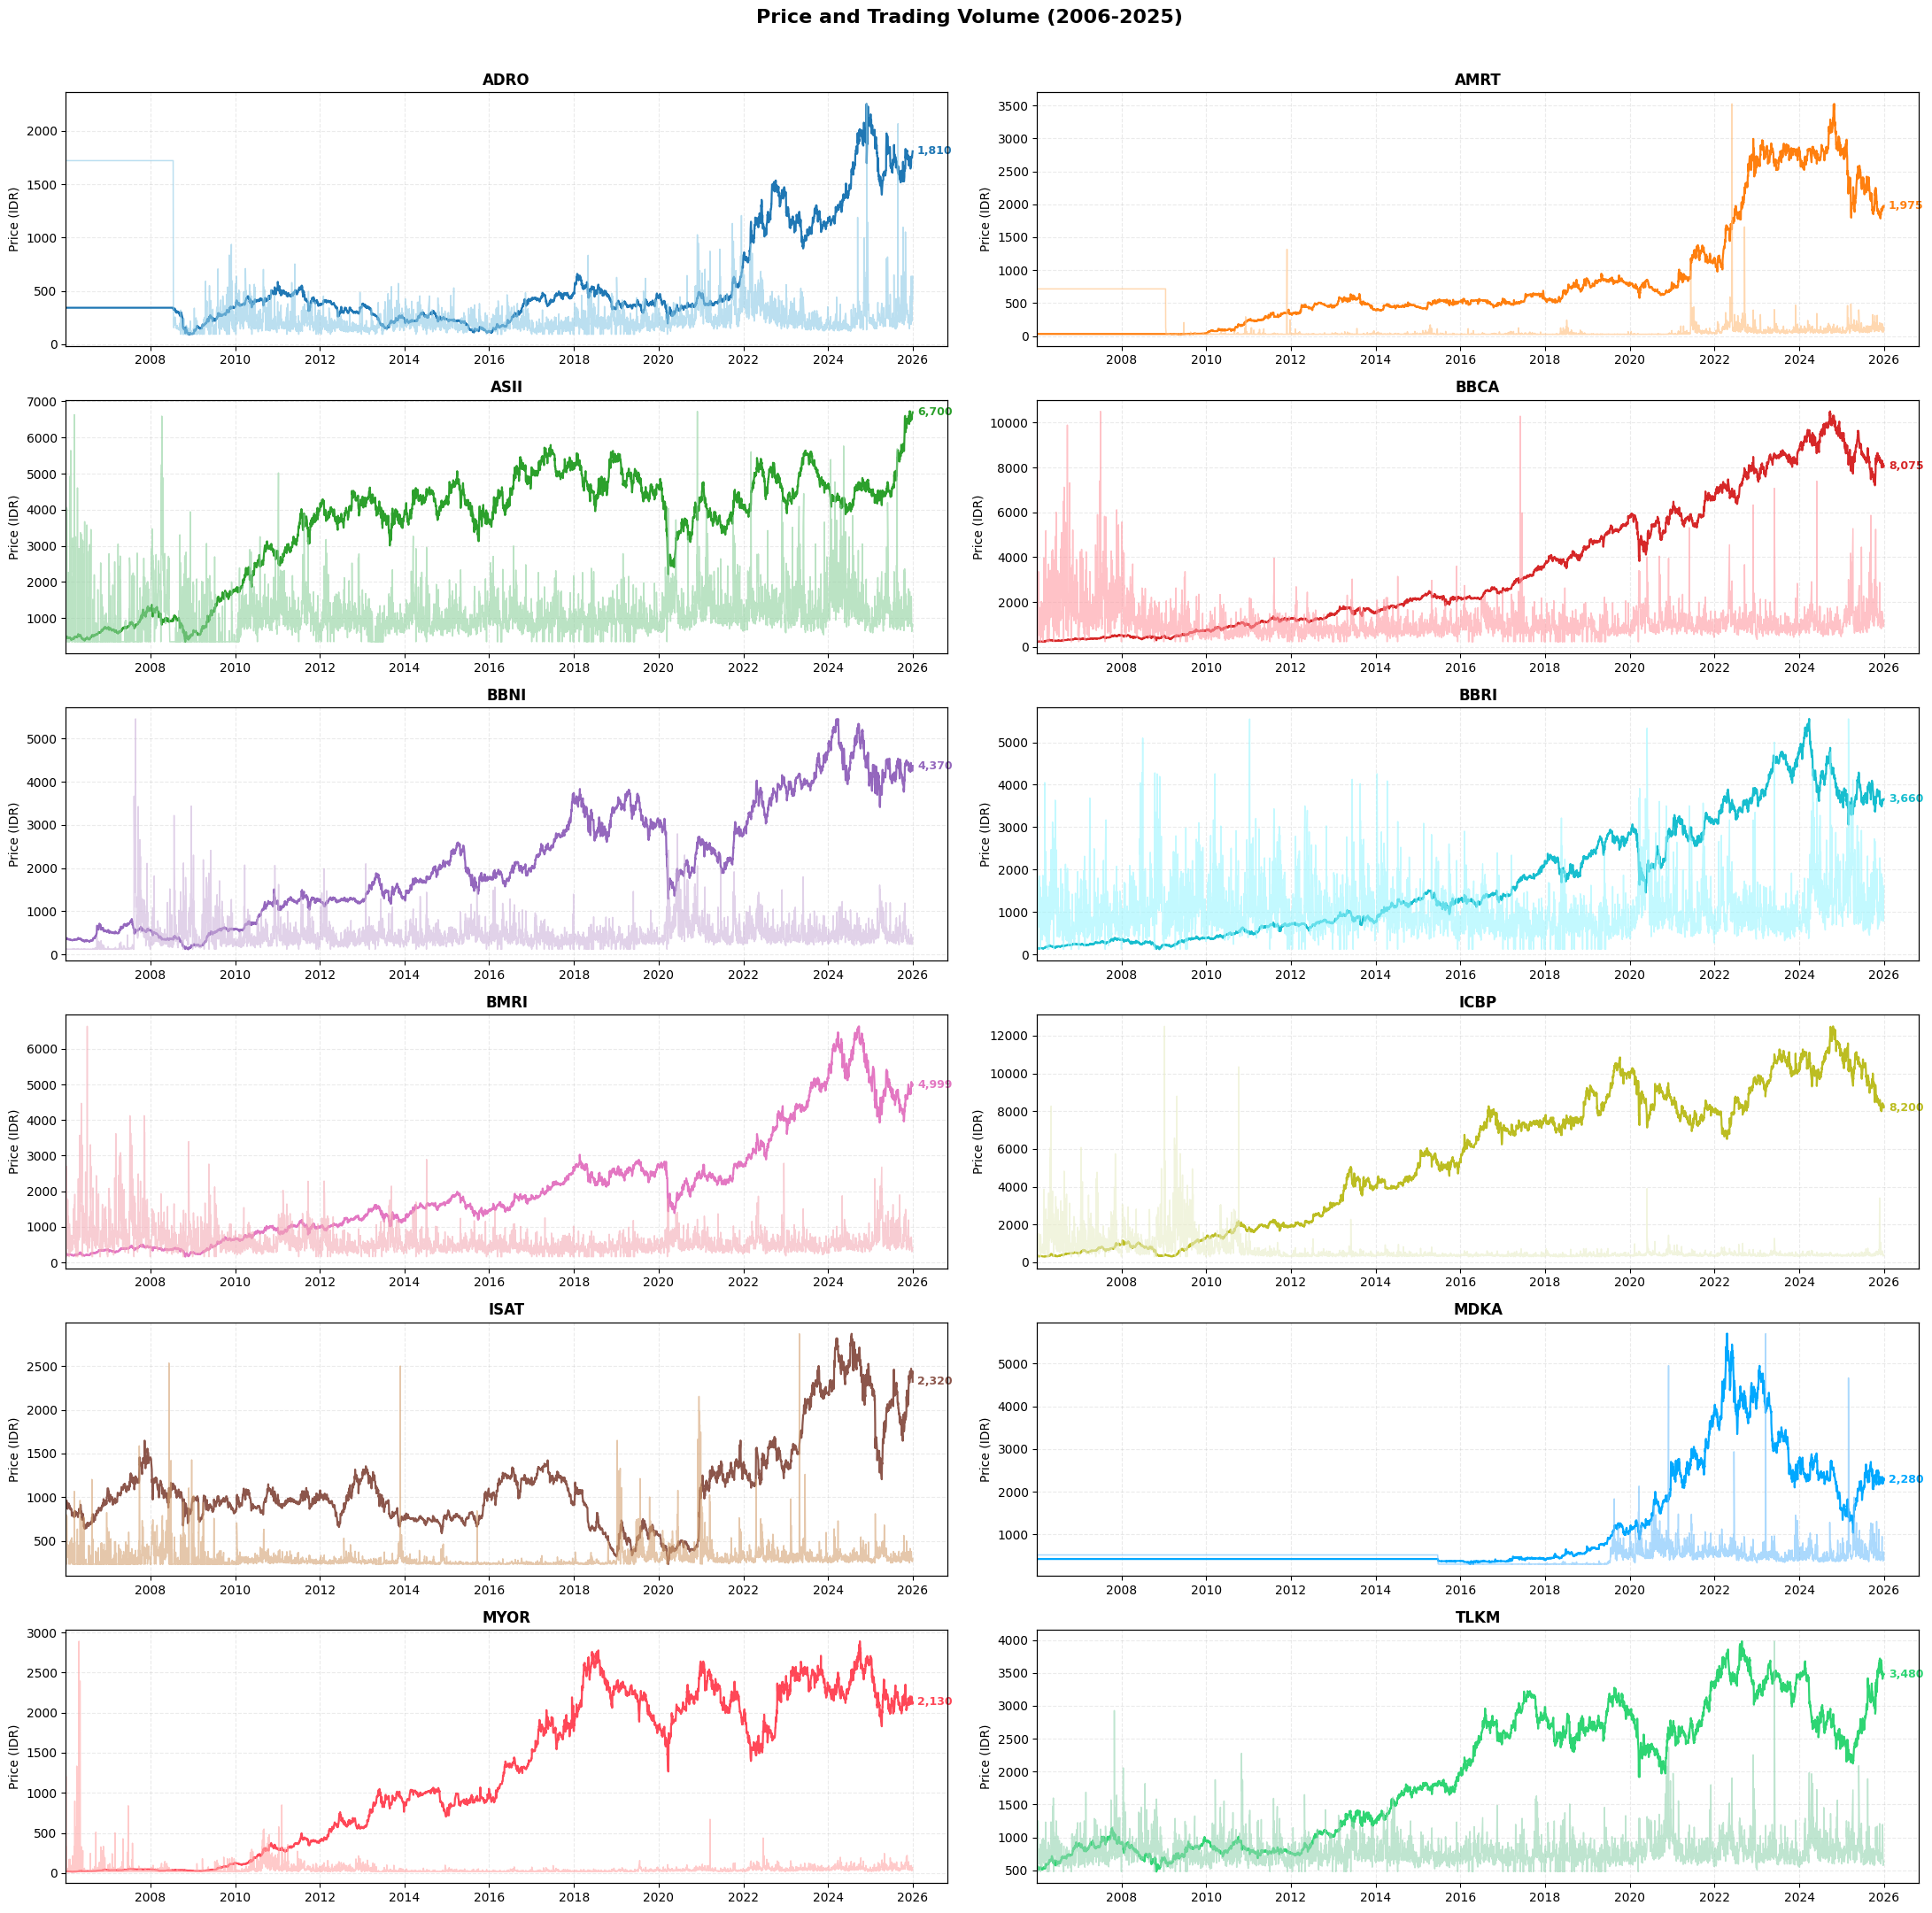

In [4]:
data_price = prices.loc['2006-01-01':'2025-12-31'].copy()
data_volume = volumes.loc['2006-01-01':'2025-12-31'].copy()
data_price.columns = data_price.columns.str.replace('.JK', '', regex=False)
data_volume.columns = data_volume.columns.str.replace('.JK', '', regex=False)
fig, axes = plt.subplots(6, 2, figsize=(22, 22))
axes = axes.flatten()
price_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#17becf', '#e377c2', '#bcbd22','#8c564b', '#00a8ff', '#ff4757', '#2ed573']
volume_colors = ['#8ecae6', '#ffbe7d', '#8fd19e', '#ff9aa2','#cdb4db', '#9bf6ff', '#f4acb7', '#e9edc9','#d4a373', '#74c0fc', '#ffa8a8', '#95d5b2']

for i, col in enumerate(data_price.columns):
    ax = axes[i]
    ax2 = ax.twinx()
    price_series = data_price[col].dropna()
    volume_series = data_volume[col].loc[price_series.index]

    if price_series.empty:
        continue

    ax.plot(price_series.index,price_series,linewidth=1.6,color=price_colors[i])
    ax2.plot(volume_series.index,volume_series,linewidth=1.1,color=volume_colors[i],alpha=0.6)
    last_date = price_series.index[-1]
    last_price = price_series.iloc[-1]
    ax.text(last_date + pd.Timedelta(days=40),last_price,f"{last_price:,.0f}",fontsize=9,fontweight='bold',color=price_colors[i],va='center')
    ax.set_title(col, fontsize=12, fontweight='bold')
    ax.set_ylabel('Price (IDR)')
    ax2.set_yticks([])
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, linestyle='--', alpha=0.25)
    ax.set_xlim(price_series.index[0],price_series.index[-1] + pd.Timedelta(days=300))

fig.suptitle('Price and Trading Volume (2006-2025)',fontsize=16,fontweight='bold',y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [5]:
# FEATURE ENGINEERING
def create_features(returns, volumes, prices):
    feats = []
    for t in returns.columns:
        ret = returns[t]
        vol_data = volumes[t]
        price_data = prices[t]

        vol = ret.rolling(20).std()
        mom1 = ret.rolling(20).mean()

        # MFI & OBV Logic
        typical_price = price_data
        money_flow = typical_price * vol_data
        delta_tp = typical_price.diff()
        pos_flow = (money_flow.where(delta_tp > 0, 0)).rolling(14).sum()
        neg_flow = (money_flow.where(delta_tp < 0, 0)).rolling(14).sum()
        mfi = 100 - (100 / (1 + (pos_flow / (neg_flow + 1e-8))))

        obv = (np.sign(price_data.diff()) * vol_data).fillna(0).cumsum()
        obv_change = obv.pct_change(20).replace([np.inf, -np.inf], 0).fillna(0)

        f = pd.concat([
            ret.rename(f"{t}_ret"), vol.rename(f"{t}_vol"),
            mom1.rename(f"{t}_mom1m"), mfi.rename(f"{t}_mfi"),
            obv_change.rename(f"{t}_obv_chg")
        ], axis=1)
        feats.append(f)

    X = pd.concat(feats, axis=1).dropna()
    y = returns.loc[X.index]
    return X, y

X_raw, y_raw = create_features(log_returns, volumes, prices)

# MODEL ARCHITECTURE
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="glorot_uniform")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)
    def call(self, x):
        et = tf.squeeze(tf.tanh(tf.matmul(x, self.W) + self.b), axis=-1)
        at = tf.nn.softmax(et)
        at = tf.expand_dims(at, axis=-1)
        return tf.reduce_sum(x * at, axis=1)

def sharpe_loss(y_true, y_pred):
    portfolio_ret = tf.reduce_sum(y_pred * y_true, axis=-1)
    mean_ret = tf.reduce_mean(portfolio_ret)
    std_ret = tf.math.reduce_std(portfolio_ret) + 1e-4
    return -(mean_ret / std_ret)

def build_model(input_shape, n_assets):
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(32, return_sequences=True)(x)
    x = AttentionLayer()(x)
    x = layers.Dense(16, activation='relu')(x)
    # Gunakan activation linear untuk output mentah skor
    out = layers.Dense(n_assets, activation='linear')(x)
    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=sharpe_loss)
    return model


# OPTIMIZATION UTILITIES
def get_sequences_forward(X, y, window, fwd):
    Xs, ys = [], []
    for i in range(len(X) - window - fwd):
        Xs.append(X.iloc[i:i+window].values)
        ys.append(y.iloc[i+window:i+window+fwd].mean().values)
    return np.array(Xs), np.array(ys)

def optimize_weights(mu, cov):
    n = len(mu)
    if n == 0: return np.array([])
    init_w = np.ones(n)/n
    res = minimize(lambda w: -(np.dot(mu, w) / (np.sqrt(w.T @ cov @ w) + 1e-8)), init_w, bounds=[(0, 1)]*n, constraints=({'type': 'eq', 'fun': lambda w: np.sum(w)-1}))
    return res.x if res.success else init_w

def softmax_dynamic(x, ticker_names, current_features, min_assets=6, max_assets=8, max_weight=0.25):
    scores = np.nan_to_num(x, nan=0.0)

    for i, t in enumerate(ticker_names):
        mfi_val = current_features.get(f"{t}_mfi", 50)
        obv_val = current_features.get(f"{t}_obv_chg", 0)
        if mfi_val > 80: scores[i] -= 2.0
        if obv_val < 0: scores[i] -= 1.0

    e = np.exp(scores - np.max(scores))
    w = e / (e.sum() + 1e-8)
    sorted_idx = np.argsort(w)[::-1]
    n_to_keep = max(min_assets, min(max_assets, np.sum(w > 0.01)))
    clean_w = np.zeros_like(w)
    keep_idx = sorted_idx[:n_to_keep]
    clean_w[keep_idx] = w[keep_idx]
    min_w = 0.05
    max_w = 0.25

    for _ in range(15):
        if clean_w.sum() == 0: break

        clean_w /= clean_w.sum()

        for idx in keep_idx:
            clean_w[idx] = np.clip(clean_w[idx], min_w, max_w)

        mask_unused = np.ones(len(clean_w), dtype=bool)
        mask_unused[keep_idx] = False
        clean_w[mask_unused] = 0.0

    if clean_w.sum() > 0:
        clean_w /= clean_w.sum()
    else:
        clean_w[sorted_idx[:6]] = 1.0 / 6.0

    return clean_w

In [6]:
years = sorted(X_raw.index.year.unique())
test_years = [y for y in years if y >= 2016]

portfolio_values = {'Model': [], 'EqualWeight': [], 'MeanVariance': []}
dates_history, weights_history, mv_weights_history = [], [], []
model_capital = ew_capital = mv_capital = 1.0
ew_weights = np.ones(len(TICKERS)) / len(TICKERS)

for year in test_years:
    print(f"Processing Year: {year}")
    train_mask = X_raw.index.year < year
    test_mask = X_raw.index.year == year

    X_train, y_train = X_raw[train_mask], y_raw[train_mask]
    X_test = X_raw[test_mask]

    mu_tr = X_train.tail(ROLLING_SCALER_DAYS).mean()
    std_tr = X_train.tail(ROLLING_SCALER_DAYS).std()

    X_all_s = (X_raw - mu_tr) / (std_tr + 1e-8)

    X_seq, y_seq = get_sequences_forward(X_all_s.loc[X_train.index], y_train, LOOKBACK_WINDOW, FORWARD_DAYS)

    model = build_model((LOOKBACK_WINDOW, X_raw.shape[1]), len(TICKERS))
    model.fit(X_seq, y_seq, epochs=12, batch_size=32, verbose=0, callbacks=[callbacks.EarlyStopping(monitor='loss', patience=3)])

    for month_date, X_month in X_test.groupby(pd.Grouper(freq=REBALANCE_FREQ)):
        if len(X_month) == 0: continue

        try:
            idx = X_all_s.index.get_loc(X_month.index[0])
            input_seq = X_all_s.iloc[idx - LOOKBACK_WINDOW : idx].values

            if len(input_seq) < LOOKBACK_WINDOW:
                model_w = ew_weights.copy()
            else:
                current_feats = X_raw.loc[X_month.index[0]]

                preds = model.predict(input_seq.reshape(1, LOOKBACK_WINDOW, -1), verbose=0)[0]
                preds = np.nan_to_num(preds, nan=0.0, posinf=0.0, neginf=0.0)
                model_w = softmax_dynamic(preds, TICKERS, current_feats, min_assets=6, max_assets=8, max_weight=0.25)

                if np.isnan(model_w).any() or np.isclose(np.sum(model_w), 0):
                    model_w = ew_weights.copy()

        except Exception as e:
            # print(f"Rebalance Error at {month_date}: {e}")
            model_w = ew_weights.copy()

        try:
            hist = y_raw.loc[y_raw.index < X_month.index[0]].tail(MV_LOOKBACK_DAYS)
            mu_mv = hist.mean() * 252

            pos_assets = mu_mv[mu_mv > 0].index
            if len(pos_assets) < 5:
                flex_idx = np.argsort(mu_mv.values)[-5:]
            else:
                flex_idx = [list(mu_mv.index).index(a) for a in pos_assets]

            w_mv_opt = optimize_weights(mu_mv.iloc[flex_idx].values, hist.iloc[:, flex_idx].cov().values * 252)

            mv_w = np.zeros(len(TICKERS))
            if len(w_mv_opt) > 0 and not np.isnan(w_mv_opt).any():
                mv_w[flex_idx] = w_mv_opt
            else:
                mv_w = ew_weights.copy()
        except:
            mv_w = ew_weights.copy()

        for date in X_month.index:
            d_ret = np.exp(y_raw.loc[date].values) - 1
            model_capital *= (1 + np.dot(model_w, d_ret))
            ew_capital    *= (1 + np.dot(ew_weights, d_ret))
            mv_capital    *= (1 + np.dot(mv_w, d_ret))
            portfolio_values['Model'].append(model_capital)
            portfolio_values['EqualWeight'].append(ew_capital)
            portfolio_values['MeanVariance'].append(mv_capital)
            dates_history.append(date)
            weights_history.append(model_w.copy())
            mv_weights_history.append(mv_w.copy())

Processing Year: 2016
Processing Year: 2017
Processing Year: 2018
Processing Year: 2019
Processing Year: 2020
Processing Year: 2021
Processing Year: 2022
Processing Year: 2023
Processing Year: 2024
Processing Year: 2025


# **(Actual Data 2016 - 2025)**

## **Cumulative Returns**

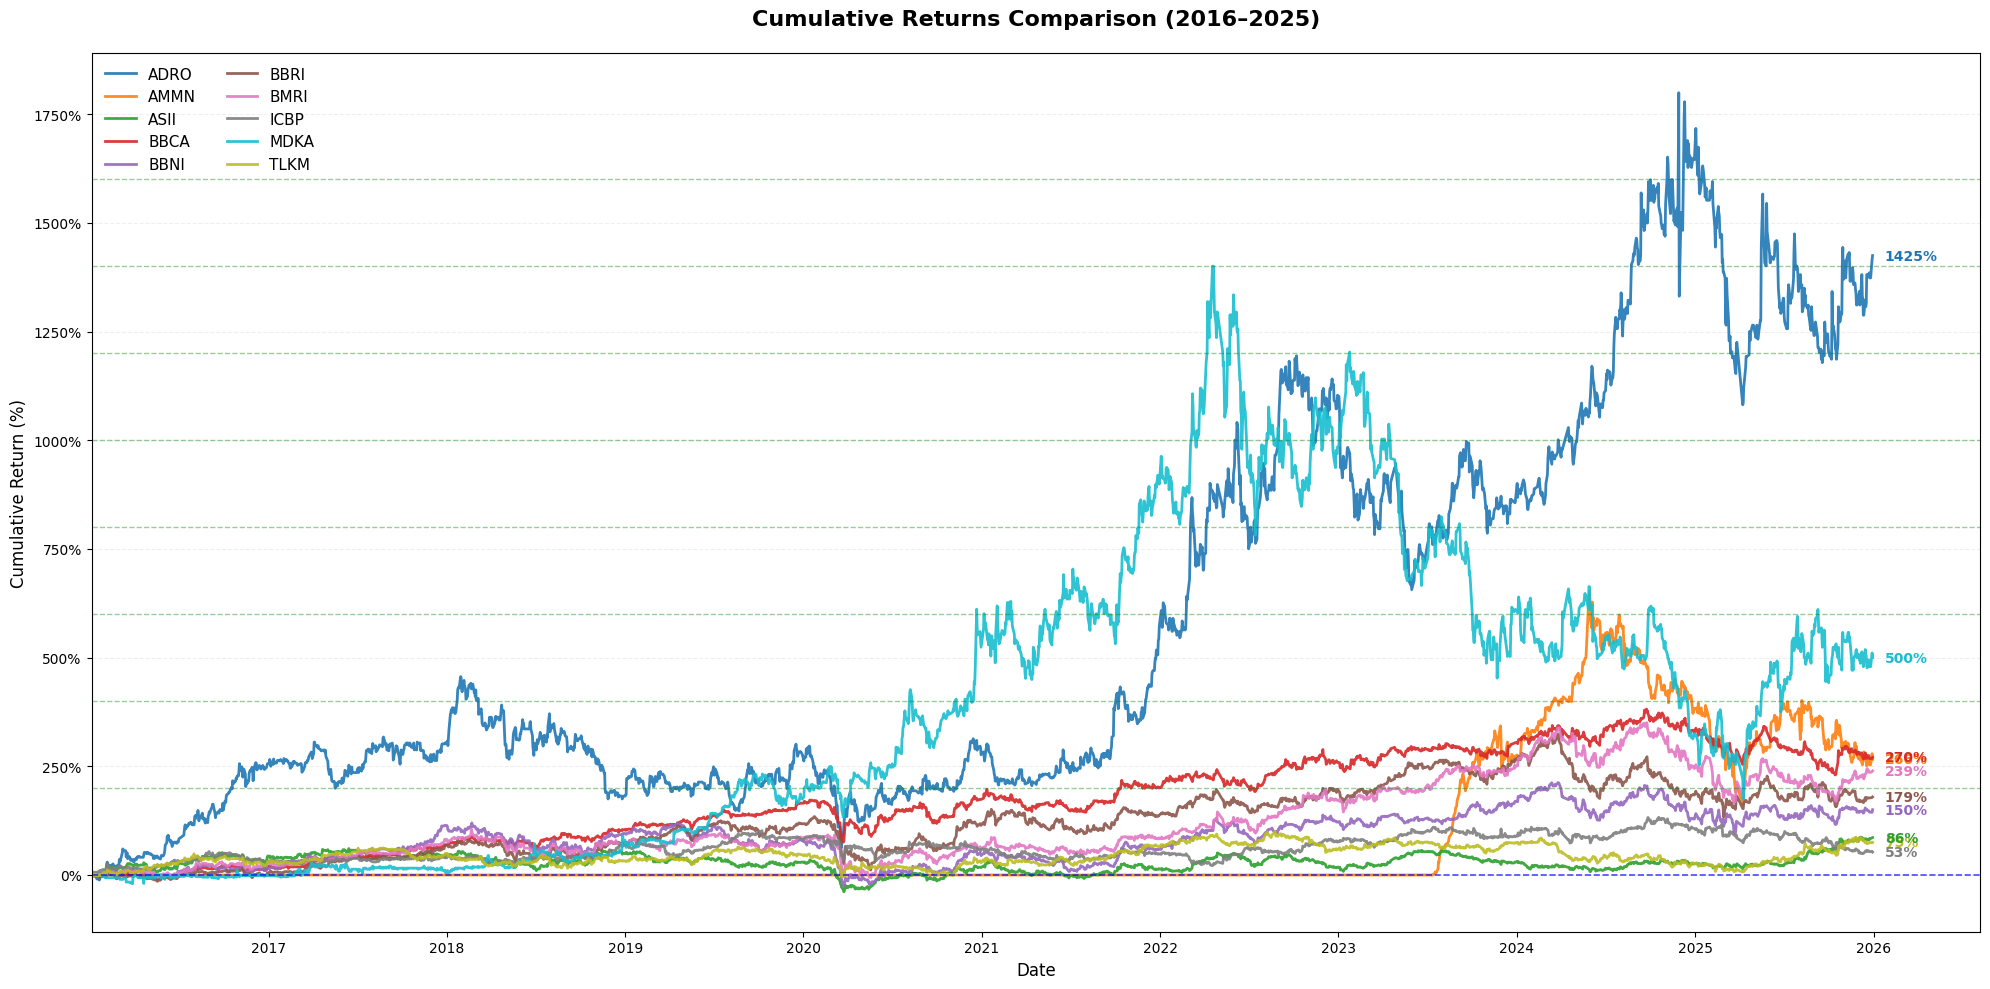

In [ ]:
data_actual_plot = prices.loc['2016-01-01':'2025-12-31'].copy()
cum_ret_assets = ((data_actual_plot / data_actual_plot.iloc[0]) - 1) * 100
fig, ax = plt.subplots(figsize=(20, 10), facecolor='white')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#17becf', '#bcbd22']

for i, col in enumerate(cum_ret_assets.columns):
    ax.plot(cum_ret_assets.index,cum_ret_assets[col],linewidth=2,alpha=0.9,label=col.replace('.JK', ''),color=colors[i])

ax.axhline(0, linestyle='--', linewidth=1.2, alpha=0.7, color='blue')

for y in range(200, 1800, 200):
    ax.axhline(y, linestyle='--', linewidth=1, alpha=0.4, color='green')

last_date = cum_ret_assets.index[-1]
offset = pd.Timedelta(days=25)

final_vals = cum_ret_assets.iloc[-1].sort_values()

for rank, col in enumerate(final_vals.index):
    y = final_vals[col]
    ax.text(last_date + offset,y,f"{y:.0f}%",fontsize=10,va='center',color=colors[list(cum_ret_assets.columns).index(col)],fontweight='bold')

ax.set_title('Cumulative Returns Comparison (2016–2025)',fontsize=16,pad=20,fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return (%)', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))
ax.legend(loc='upper left',frameon=False,ncol=2,fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.2)
ax.grid(axis='x', alpha=0)
ax.set_xlim(cum_ret_assets.index[0],last_date + pd.Timedelta(days=220))
plt.tight_layout()
plt.show()

## **Drawdown Analysis**

0% Drawdown
1. Artinya portofolio tidak mengalami penurunan dari nilai tertingginya.
2. Portofolio selalu naik atau stabil, tidak ada kerugian sementara.

Drawdown positif (misal 10%, 20%)
1. Artinya portofolio turun sekian persen dari puncak sebelumnya.
2. Menunjukkan risiko penurunan nilai investasi yang pernah terjadi.

Drawdown tinggi (misal >50%)
1. Artinya portofolio mengalami penurunan besar dari puncak sebelumnya.
2. Risiko ekstrem, investor mengalami kerugian signifikan sebelum bisa kembali ke level awal.


Semakin rendah Drawdown, portofolio lebih stabil dan risiko kerugian lebih kecil.

Semakin tinggi Drawdown, portofolio lebih berisiko dan fluktuasi nilainya besar.

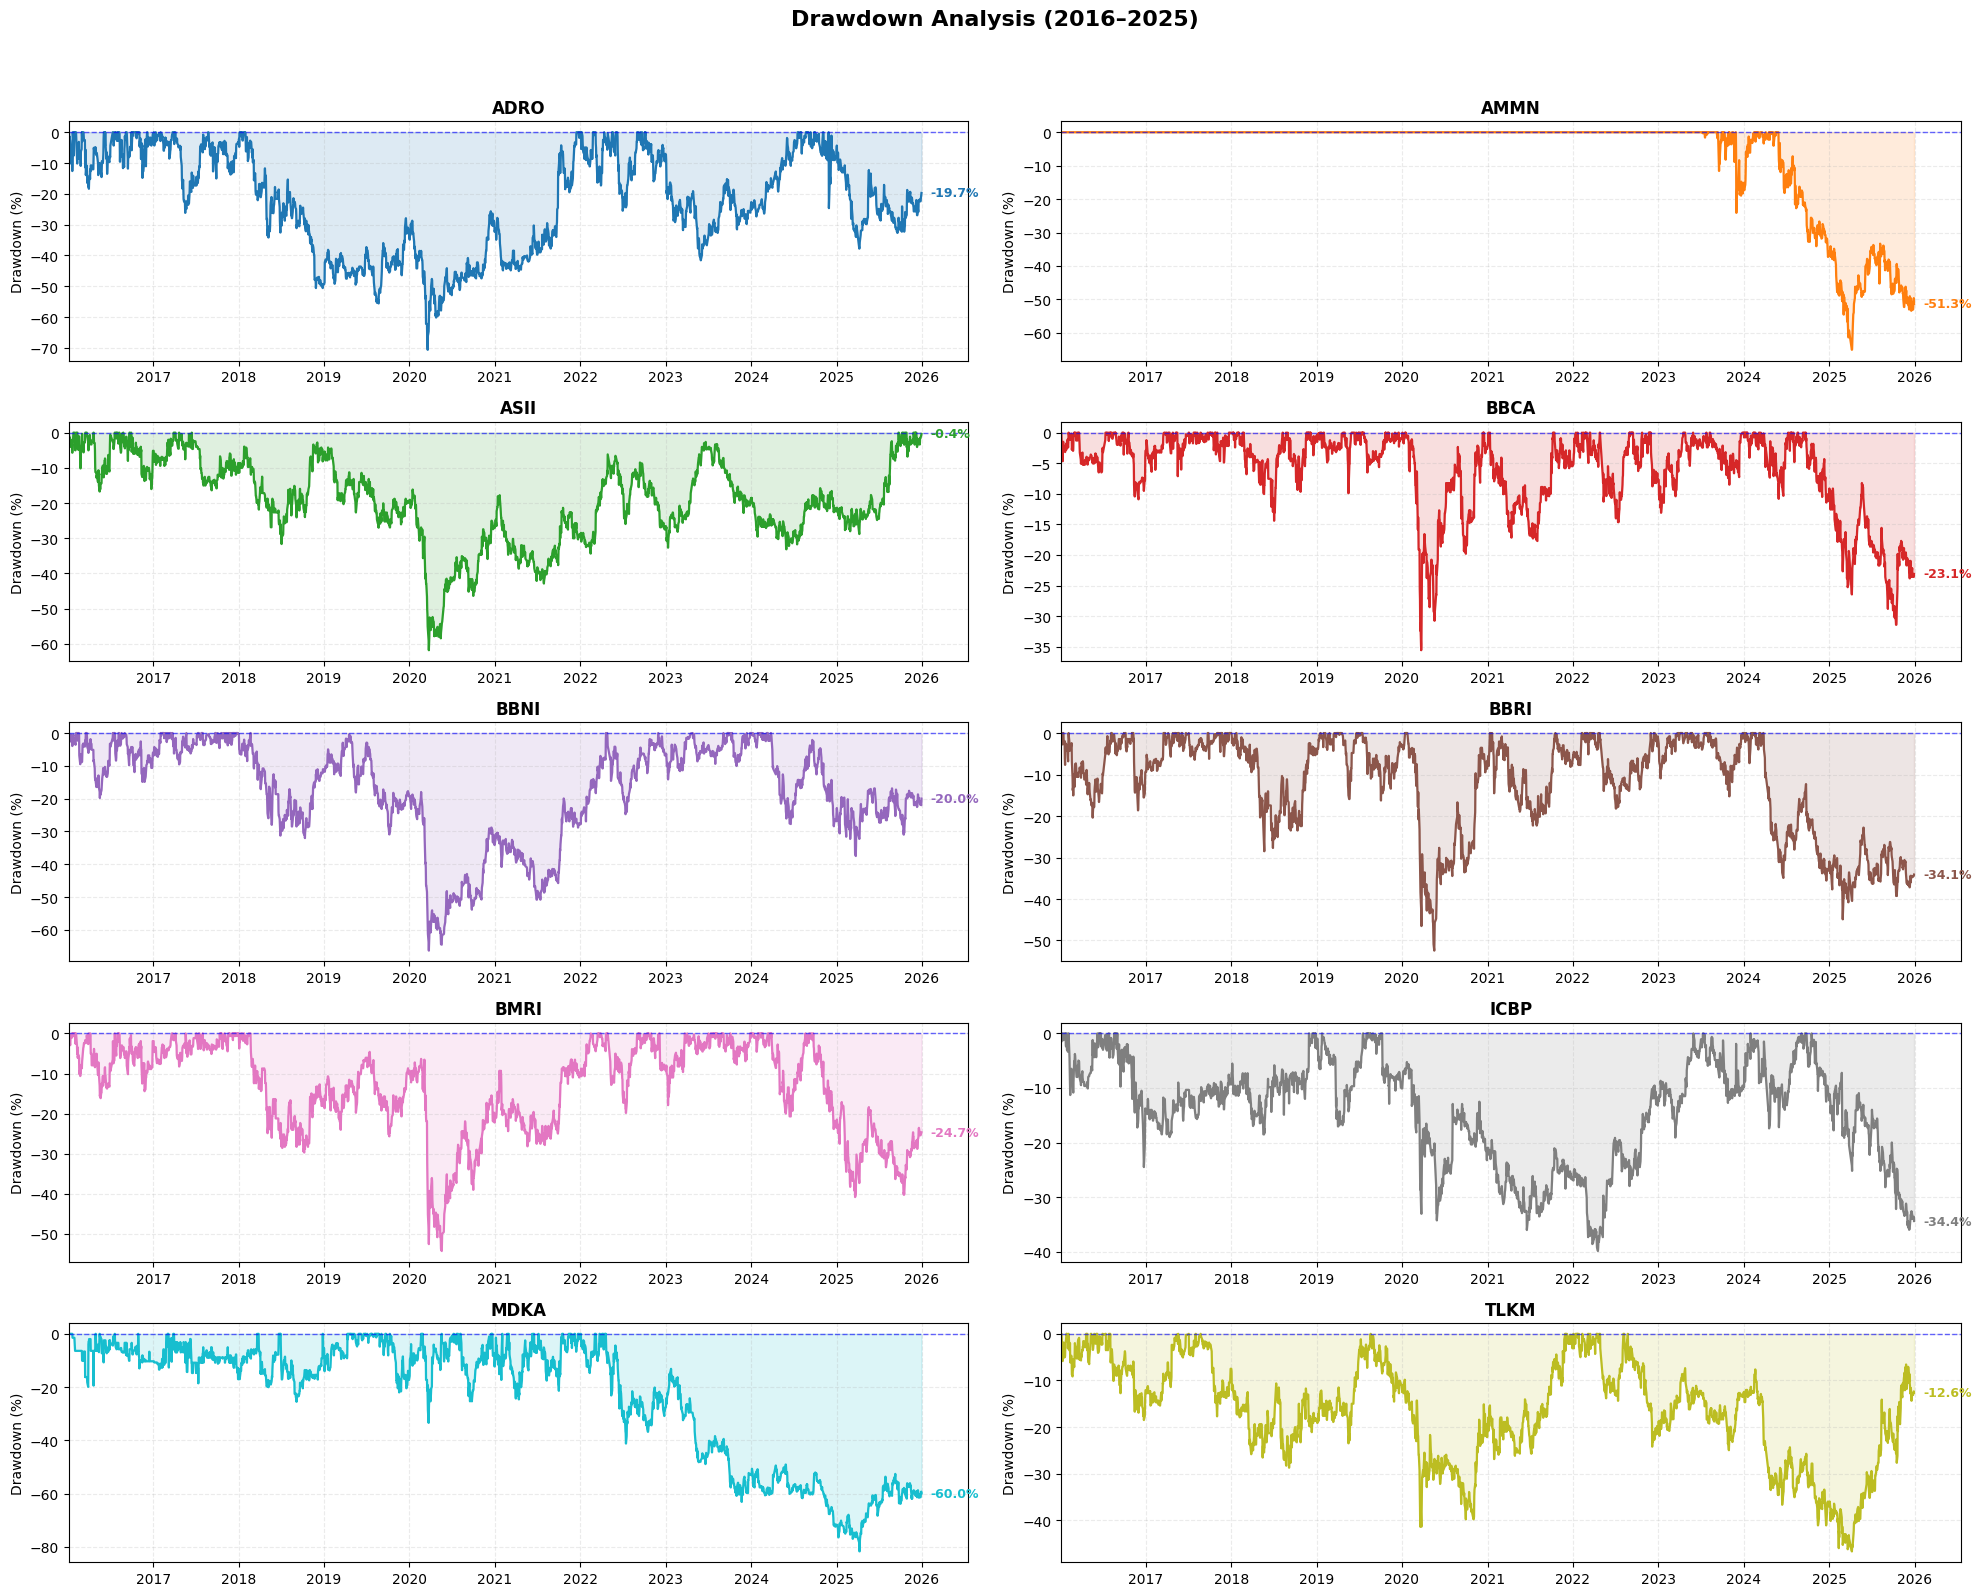

In [ ]:
data_drawdown = prices.loc['2016-01-01':'2025-12-31']
rolling_max = data_drawdown.cummax()
drawdowns_pct = (data_drawdown / rolling_max - 1) * 100
fig, axes = plt.subplots(5, 2, figsize=(20, 16), sharex=False)
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#17becf', '#bcbd22']

for i, col in enumerate(drawdowns_pct.columns):
    ax = axes[i]
    ax.plot(drawdowns_pct.index,drawdowns_pct[col],linewidth=1.6,color=colors[i])
    ax.fill_between(drawdowns_pct.index,drawdowns_pct[col],0,color=colors[i],alpha=0.15)
    ax.axhline(0, linestyle='--', linewidth=1, alpha=0.6, color='blue')
    last_date = drawdowns_pct.index[-1]
    last_value = drawdowns_pct[col].iloc[-1]
    ax.text(last_date + pd.Timedelta(days=40),last_value,f"{last_value:.1f}%",fontsize=9,va='center',fontweight='bold',color=colors[i])
    ax.set_title(col.replace('.JK', ''), fontsize=12, fontweight='bold')
    ax.set_ylabel('Drawdown (%)')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, linestyle='--', alpha=0.25)
    ax.set_xlim(drawdowns_pct.index[0],drawdowns_pct.index[-1] + pd.Timedelta(days=200))

fig.suptitle('Drawdown Analysis (2016–2025)',fontsize=16,y=0.995,fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## **Sharpe Ratio Analysis**

0 Sharpe Ratio
1. Artinya return portofolio sama dengan aset bebas risiko, tidak ada kompensasi untuk risiko.
2. Portofolio tidak menghasilkan keuntungan tambahan dibanding menaruh uang di aset aman.

Sharpe Ratio positif
1. Artinya portofolio memberikan return lebih besar dari risiko yang diambil.
2. Semakin tinggi angkanya, semakin efisien portofolio menghasilkan return per unit risiko.

Sharpe Ratio negatif
1. Artinya portofolio merugi dibanding aset bebas risiko, investor tidak mendapat kompensasi atas risiko yang diambil.
2. Menunjukkan performa portofolio buruk atau strategi tidak efektif.


Semakin tinggi Sharpe Ratio, semakin baik portofolio dalam memanfaatkan risiko untuk menghasilkan return.


Semakin rendah atau negatif, portofolio kurang efisien atau bahkan merugikan.


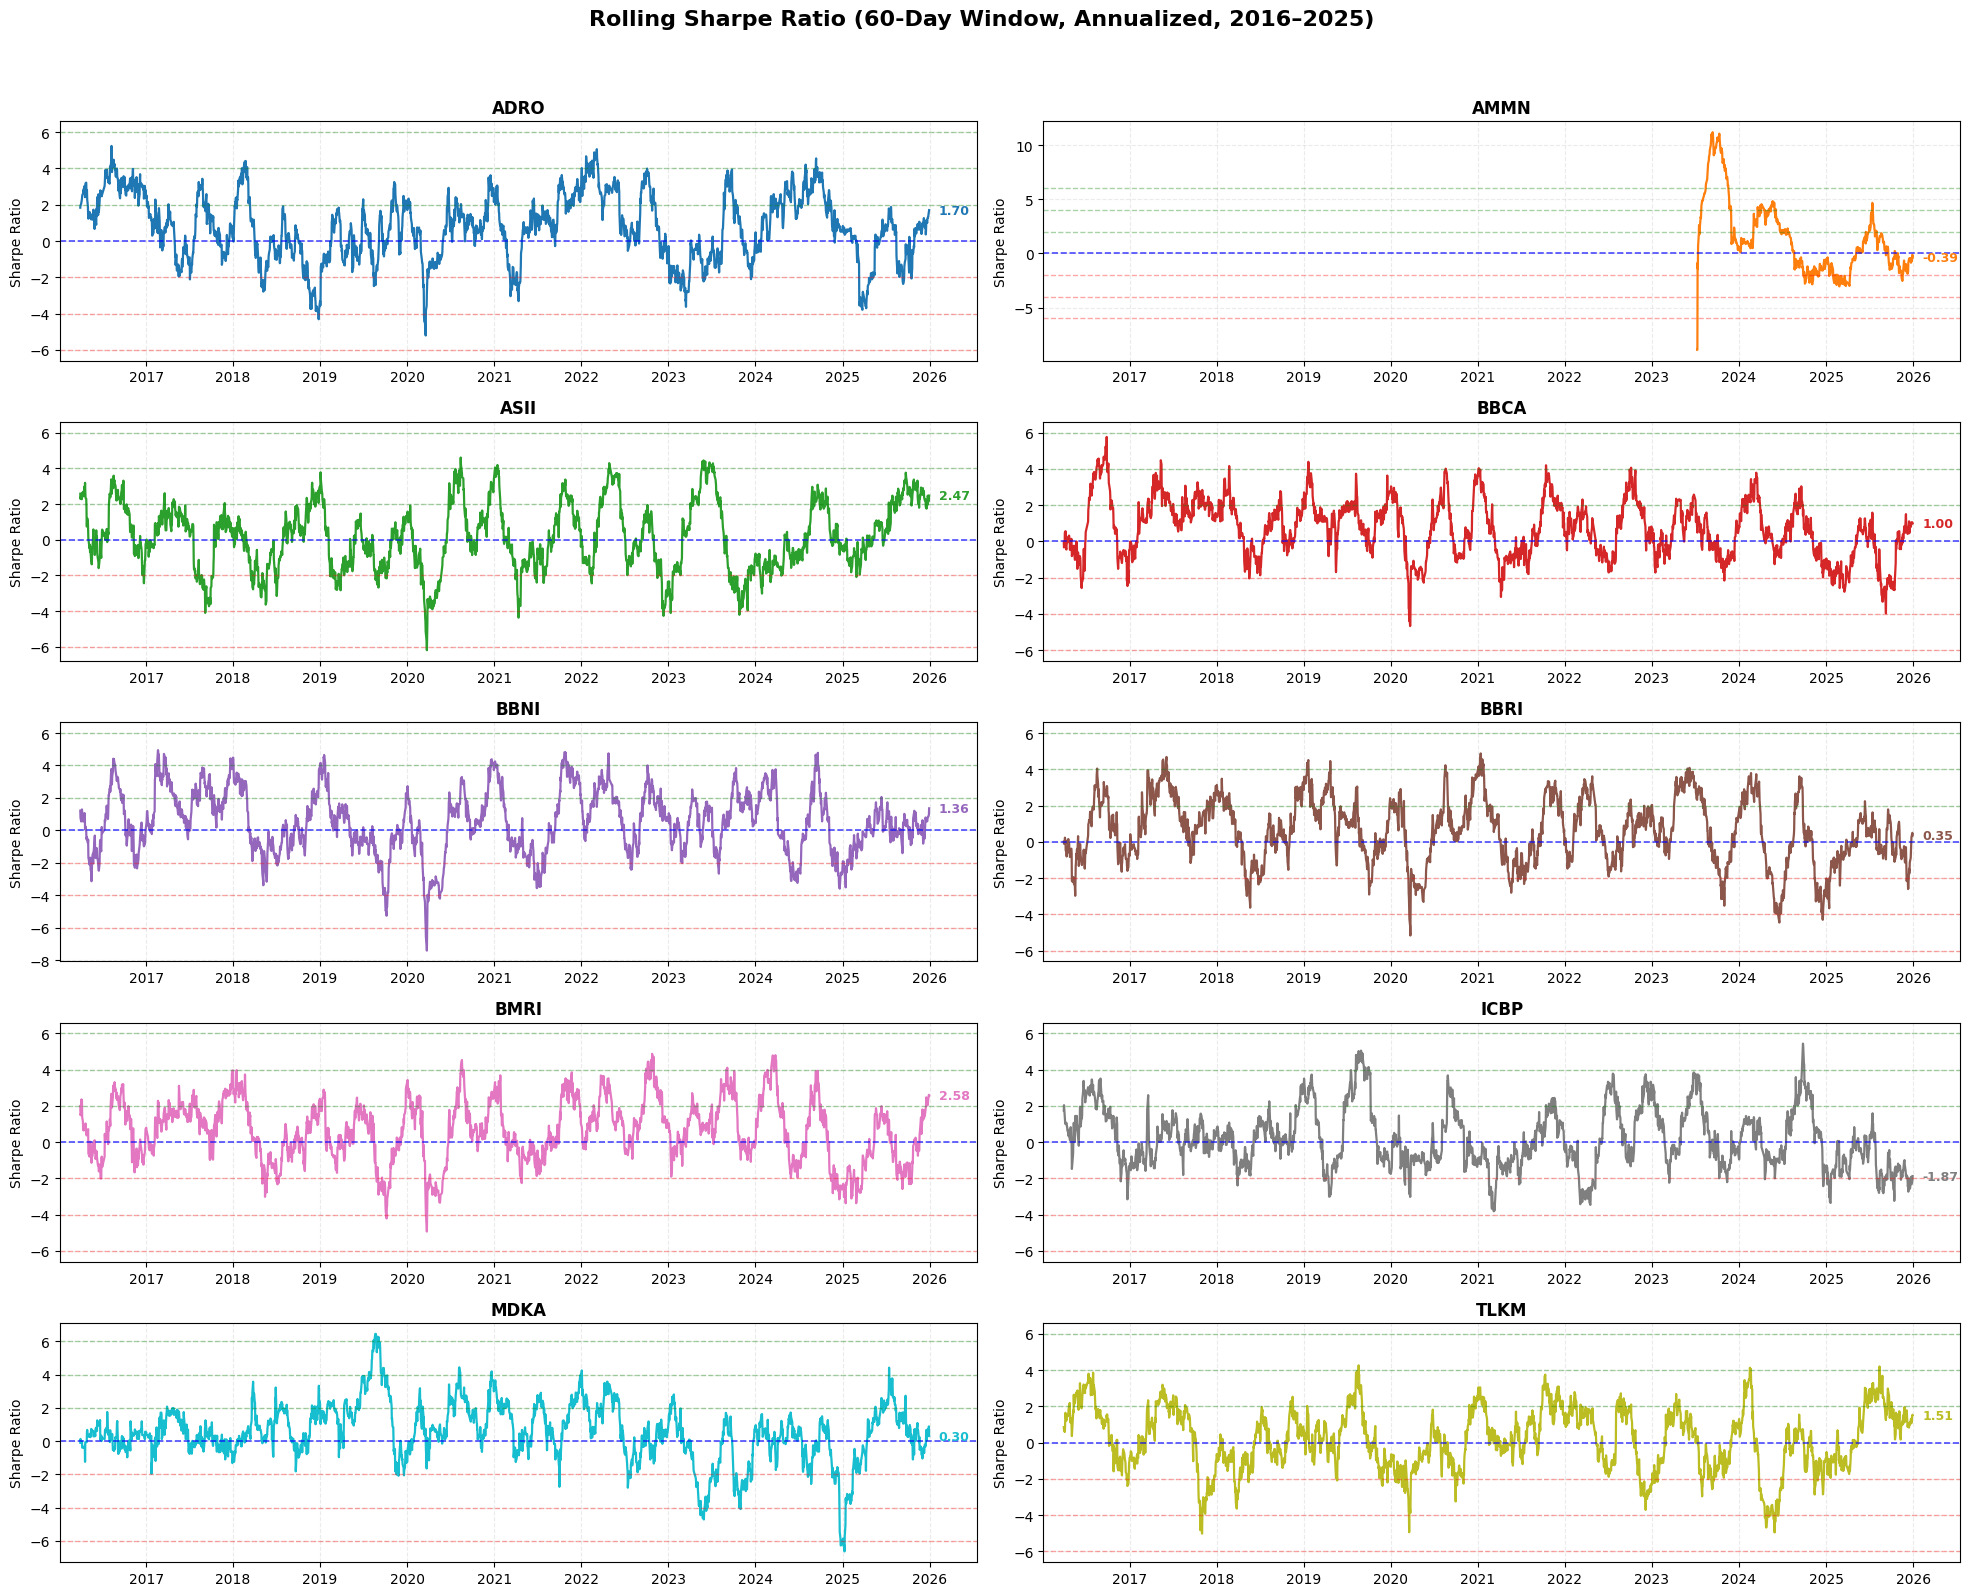

In [ ]:
prices_eval = prices.loc['2016-01-01':'2025-12-31']
daily_returns = prices_eval.pct_change().dropna()

window = 60
trading_days = 252
risk_free_rate_annual = 0.04

risk_free_rate_daily = risk_free_rate_annual / trading_days
excess_returns = daily_returns - risk_free_rate_daily
rolling_sharpe = (excess_returns.rolling(window).mean() /excess_returns.rolling(window).std()) * np.sqrt(trading_days)

fig, axes = plt.subplots(5, 2, figsize=(20, 16), sharex=False)
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#17becf', '#bcbd22']

for i, col in enumerate(rolling_sharpe.columns):
    ax = axes[i]
    ax.plot(rolling_sharpe.index,rolling_sharpe[col],linewidth=1.6,color=colors[i])
    ax.axhline(0, linestyle='--', linewidth=1.2, alpha=0.7, color='blue')

    for y in [2, 4, 6]:
        ax.axhline(y, linestyle='--', linewidth=1, alpha=0.35, color='green')

    for y in [-2, -4, -6]:
        ax.axhline(y, linestyle='--', linewidth=1, alpha=0.35, color='red')

    last_date = rolling_sharpe.index[-1]
    last_value = rolling_sharpe[col].iloc[-1]

    if not np.isnan(last_value):
        ax.text(last_date + pd.Timedelta(days=40),last_value,f"{last_value:.2f}",fontsize=9,va='center',fontweight='bold',color=colors[i])

    ax.set_title(col.replace('.JK', ''), fontsize=12, fontweight='bold')
    ax.set_ylabel('Sharpe Ratio')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, linestyle='--', alpha=0.25)
    ax.set_xlim(rolling_sharpe.index[0],rolling_sharpe.index[-1] + pd.Timedelta(days=200))

fig.suptitle('Rolling Sharpe Ratio (60-Day Window, Annualized, 2016–2025)',fontsize=16,y=0.995,fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## **Volatility Analysis**

0% volatility
1. Artinya harga aset tidak bergerak sama sekali selama periode yang dihitung.
2. Tidak ada fluktuasi harian, portofolio atau saham “stabil sempurna”.
3. Dalam praktik nyata hampir tidak pernah terjadi kecuali saham tidak diperdagangkan.

100% volatility
1. Artinya harga aset bergerak sangat besar dalam setahun.
2. Jika saham bernilai 100, bisa bergerak ±100 dalam setahun.
3. Menunjukkan risiko ekstrem, investasi sangat tidak stabil.


Semakin tinggi persentase, semakin besar fluktuasi dan risiko.

Semakin rendah persentase, harga lebih stabil, risiko lebih kecil.

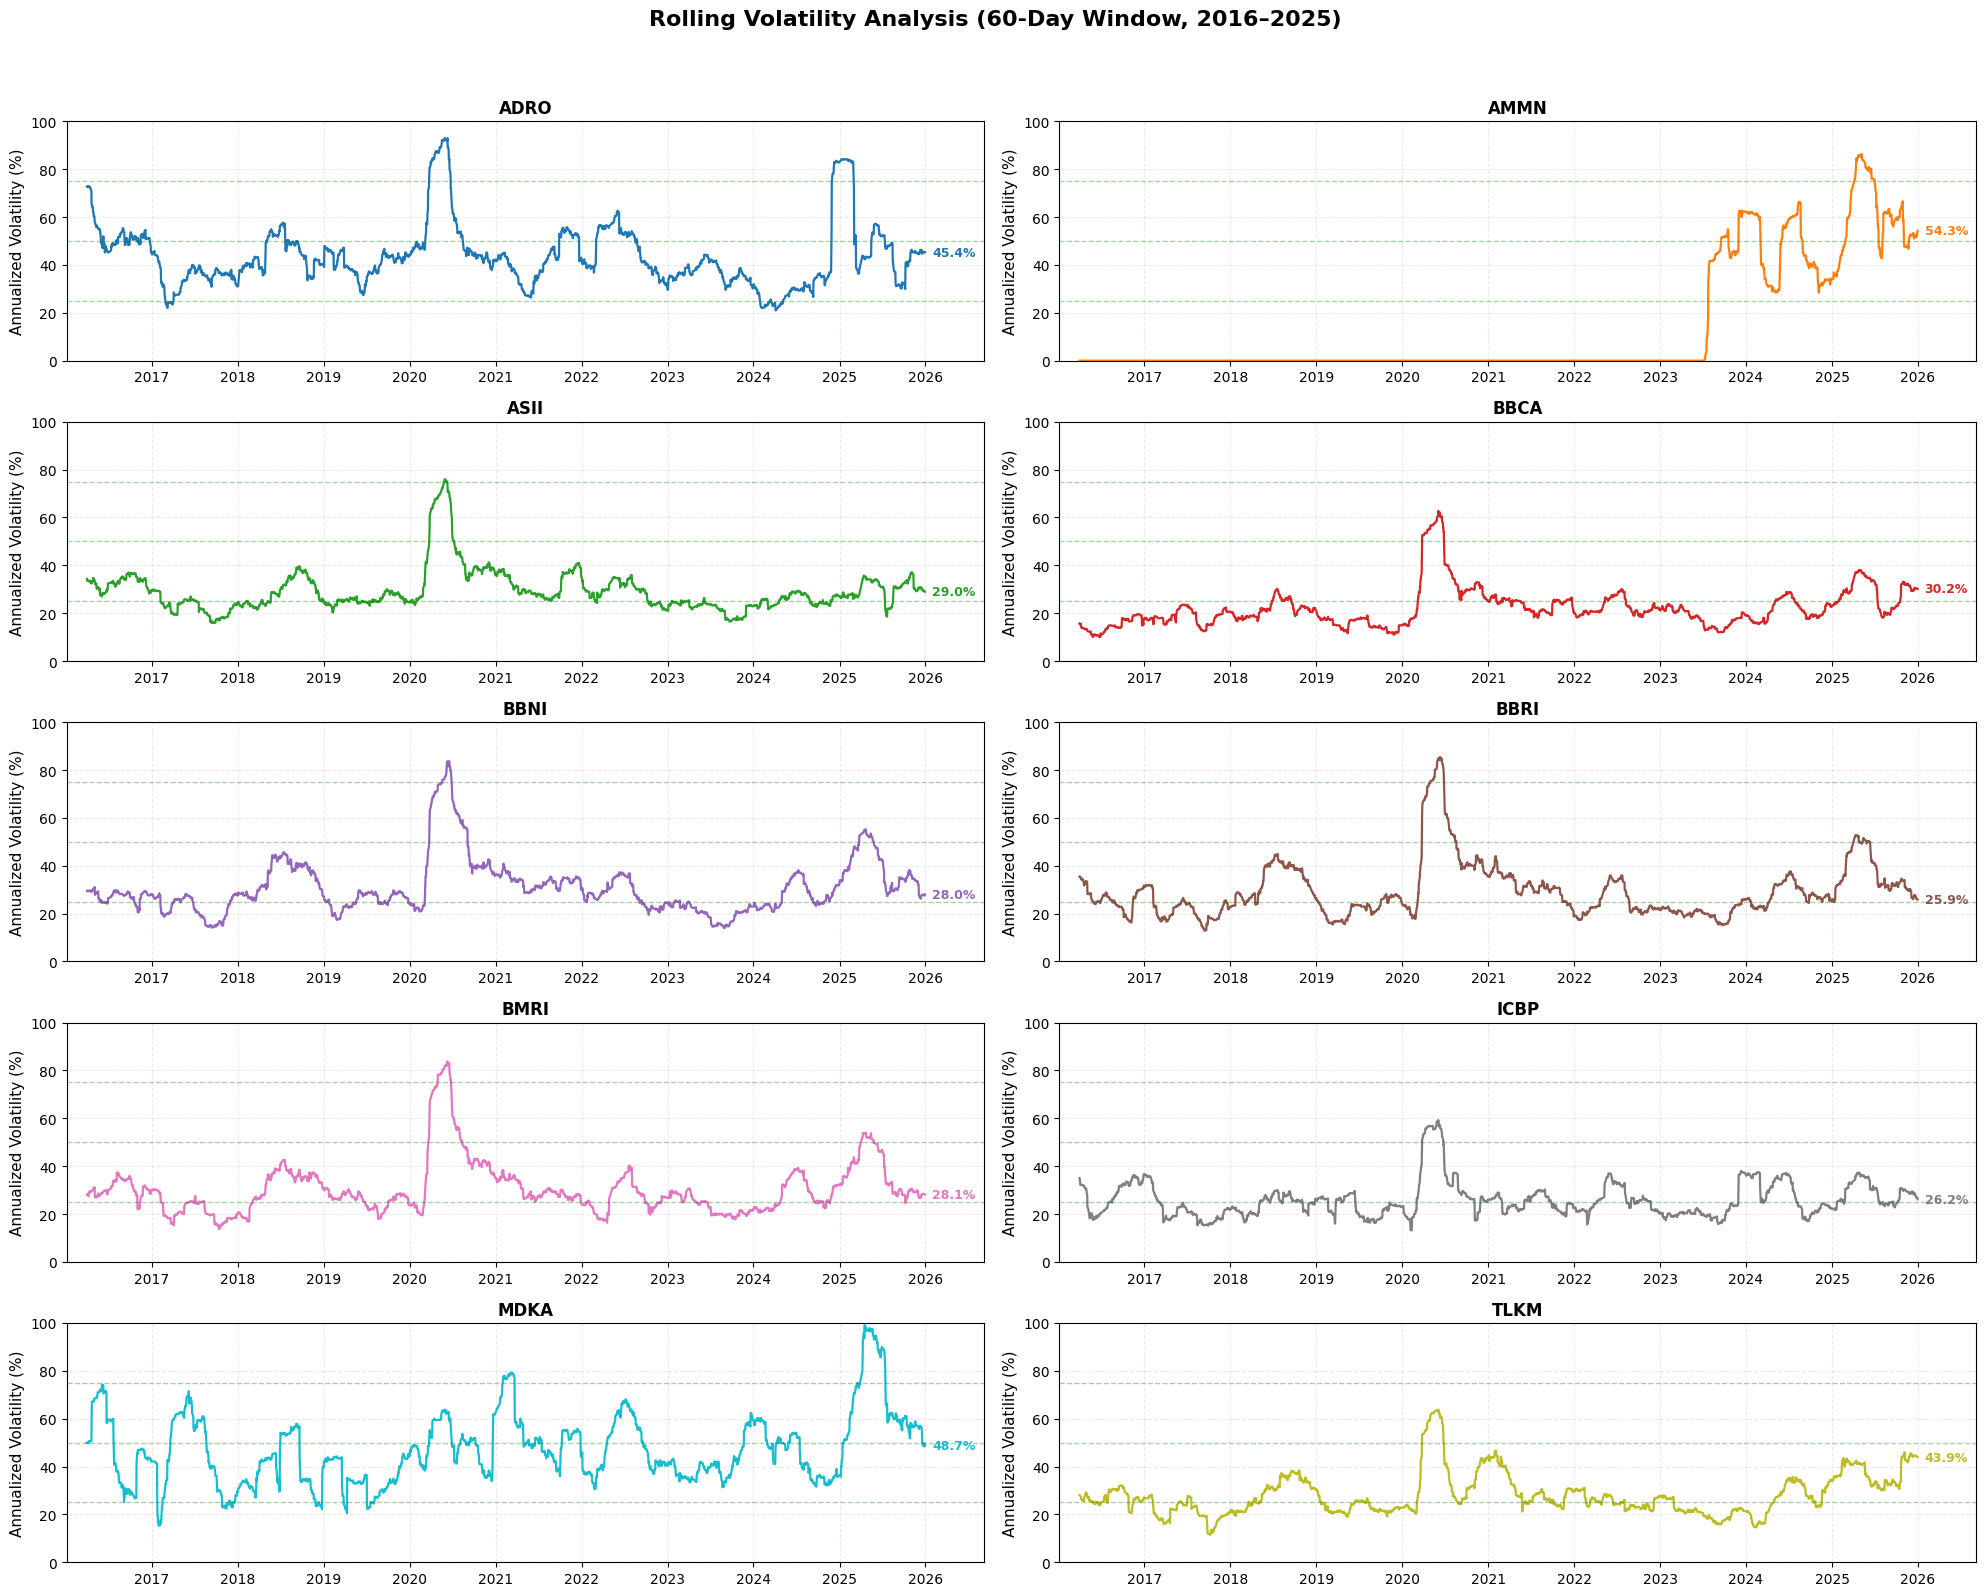

In [ ]:
data_vol = prices.loc['2016-01-01':'2025-12-31']
daily_returns = data_vol.pct_change().dropna()
window = 60
rolling_vol = daily_returns.rolling(window).std() * np.sqrt(252) * 100
fig, axes = plt.subplots(5, 2, figsize=(20, 16), sharey=True)
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#17becf', '#bcbd22']
y_ticks = np.arange(0, 101, 20)

for i, col in enumerate(rolling_vol.columns):
    ax = axes[i]
    ax.plot(rolling_vol.index,rolling_vol[col],linewidth=1.6,color=colors[i])

    for y in [25, 50, 75]:
        ax.axhline(y,linestyle='--',linewidth=1,alpha=0.35,color='green')

    ax.set_title(col.replace('.JK', ''), fontsize=12, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.set_yticks(y_ticks)
    ax.set_ylabel('Annualized Volatility (%)', fontsize=11)
    ax.tick_params(axis='y', labelleft=True)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, linestyle='--', alpha=0.25)
    last_date = rolling_vol.index[-1]
    val = rolling_vol[col].iloc[-1]

    if not np.isnan(val):
        ax.text(last_date + pd.Timedelta(days=30),val,f"{val:.1f}%",fontsize=9,fontweight='bold',va='center',color=colors[i])

    ax.set_xlim(rolling_vol.index[0],last_date + pd.Timedelta(days=250))

fig.suptitle('Rolling Volatility Analysis (60-Day Window, 2016–2025)',fontsize=16,fontweight='bold',y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## **Correlation Heatmap**

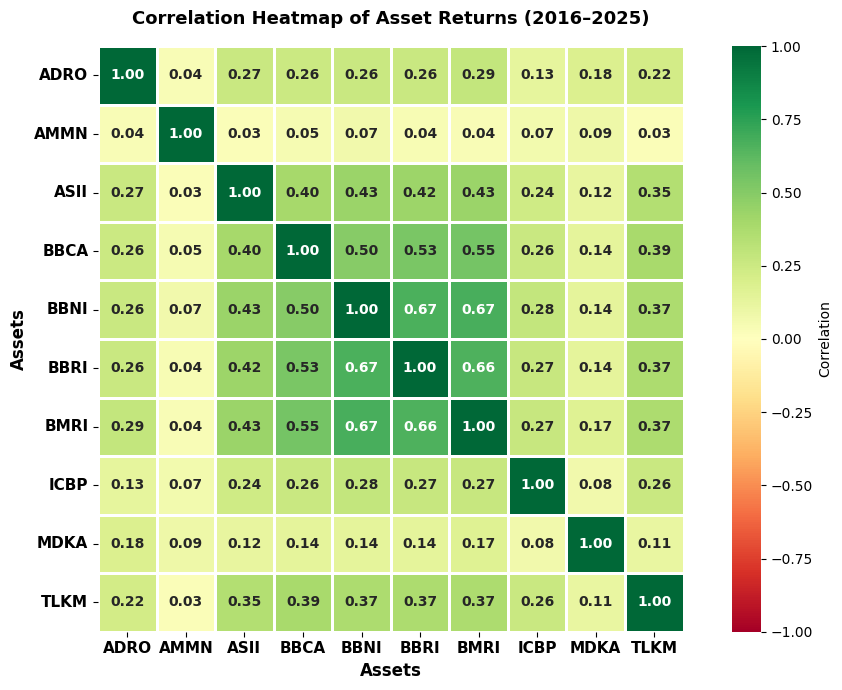

In [ ]:
prices_eval = prices.loc['2016-01-01':'2025-12-31']
prices_eval.columns = prices_eval.columns.str.replace('.JK', '', regex=False)
daily_returns = prices_eval.pct_change().dropna()
corr_matrix = daily_returns.corr()
plt.figure(figsize=(10, 7), facecolor='white')
ax = sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap='RdYlGn',vmin=-1,vmax=1,square=True,linewidths=1,annot_kws={"fontsize": 10, "fontweight": "bold"},cbar_kws={"label": "Correlation"})
ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=11,fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(),rotation=0,fontsize=11,fontweight='bold')
ax.set_ylabel("Assets", fontsize=12, fontweight='bold')
ax.set_xlabel("Assets", fontsize=12, fontweight='bold')
plt.title("Correlation Heatmap of Asset Returns (2016–2025)",fontsize=13,fontweight='bold',pad=16)
plt.tight_layout()
plt.show()

# **Result Model , Equal Weight & Mean Variance**

In [7]:
results_df = pd.DataFrame(portfolio_values, index=pd.to_datetime(dates_history))
results_df = results_df.loc[~results_df.index.duplicated(keep='last')].sort_index()
weights_df = pd.DataFrame(weights_history, index=pd.to_datetime(dates_history), columns=TICKERS)
weights_df = weights_df.loc[~weights_df.index.duplicated(keep='last')].sort_index()
mv_weights_df = pd.DataFrame(mv_weights_history, index=pd.to_datetime(dates_history), columns=TICKERS)
mv_weights_df = mv_weights_df.loc[~mv_weights_df.index.duplicated(keep='last')].sort_index()

def calculate_performance_metrics(equity_curve):
    equity_curve = equity_curve.dropna()
    if len(equity_curve) < 2: return [np.nan] * 5
    total_return = equity_curve.iloc[-1] / equity_curve.iloc[0] - 1
    days = (equity_curve.index[-1] - equity_curve.index[0]).days
    annual_return = (1 + total_return) ** (365 / max(days, 1)) - 1
    daily_returns = equity_curve.pct_change().dropna()
    annual_vol = daily_returns.std() * np.sqrt(252)
    sharpe = annual_return / annual_vol if annual_vol > 0 else np.nan
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    max_dd = drawdown.min()
    return [total_return * 100, annual_return * 100, annual_vol * 100, sharpe, max_dd * 100]

metrics_table = pd.DataFrame(
    {
        "Deep Learning (Improved)": calculate_performance_metrics(results_df["Model"]),
        "Equal Weight": calculate_performance_metrics(results_df["EqualWeight"]),
        "Mean Variance": calculate_performance_metrics(results_df["MeanVariance"])
    },
    index=["Total Return (%)", "Annualized Return (%)", "Annualized Volatility (%)", "Sharpe Ratio", "Max Drawdown (%)"]
).round(2)

print(metrics_table)

                           Deep Learning (Improved)  Equal Weight  \
Total Return (%)                             399.77        385.53   
Annualized Return (%)                         17.47         17.13   
Annualized Volatility (%)                     21.22         19.05   
Sharpe Ratio                                   0.82          0.90   
Max Drawdown (%)                             -38.07        -40.58   

                           Mean Variance  
Total Return (%)                  356.72  
Annualized Return (%)              16.41  
Annualized Volatility (%)          24.53  
Sharpe Ratio                        0.67  
Max Drawdown (%)                  -35.00  


In [8]:
results_df = pd.DataFrame(portfolio_values, index=pd.to_datetime(dates_history))
results_df = results_df.loc[~results_df.index.duplicated(keep='last')].sort_index()

def calculate_performance_metrics(equity_curve):
    total_return = equity_curve.iloc[-1] / equity_curve.iloc[0] - 1
    annual_return = (1 + total_return) ** (365 / max((equity_curve.index[-1] - equity_curve.index[0]).days, 1)) - 1
    vol = equity_curve.pct_change().std() * np.sqrt(252)
    max_dd = ((equity_curve - equity_curve.cummax()) / equity_curve.cummax()).min()
    return [total_return*100, annual_return*100, vol*100, annual_return/vol, max_dd*100]

metrics = pd.DataFrame({
    "DL (Improved)": calculate_performance_metrics(results_df["Model"]),
    "Equal Weight": calculate_performance_metrics(results_df["EqualWeight"]),
    "Mean Variance": calculate_performance_metrics(results_df["MeanVariance"])
}, index=["Total Return (%)", "Annualized Return (%)", "Vol (%)", "Sharpe", "Max DD (%)"]).round(2)

print(metrics)

                       DL (Improved)  Equal Weight  Mean Variance
Total Return (%)              399.77        385.53         356.72
Annualized Return (%)          17.47         17.13          16.41
Vol (%)                        21.22         19.05          24.53
Sharpe                          0.82          0.90           0.67
Max DD (%)                    -38.07        -40.58         -35.00


## **Cumulative Returns**

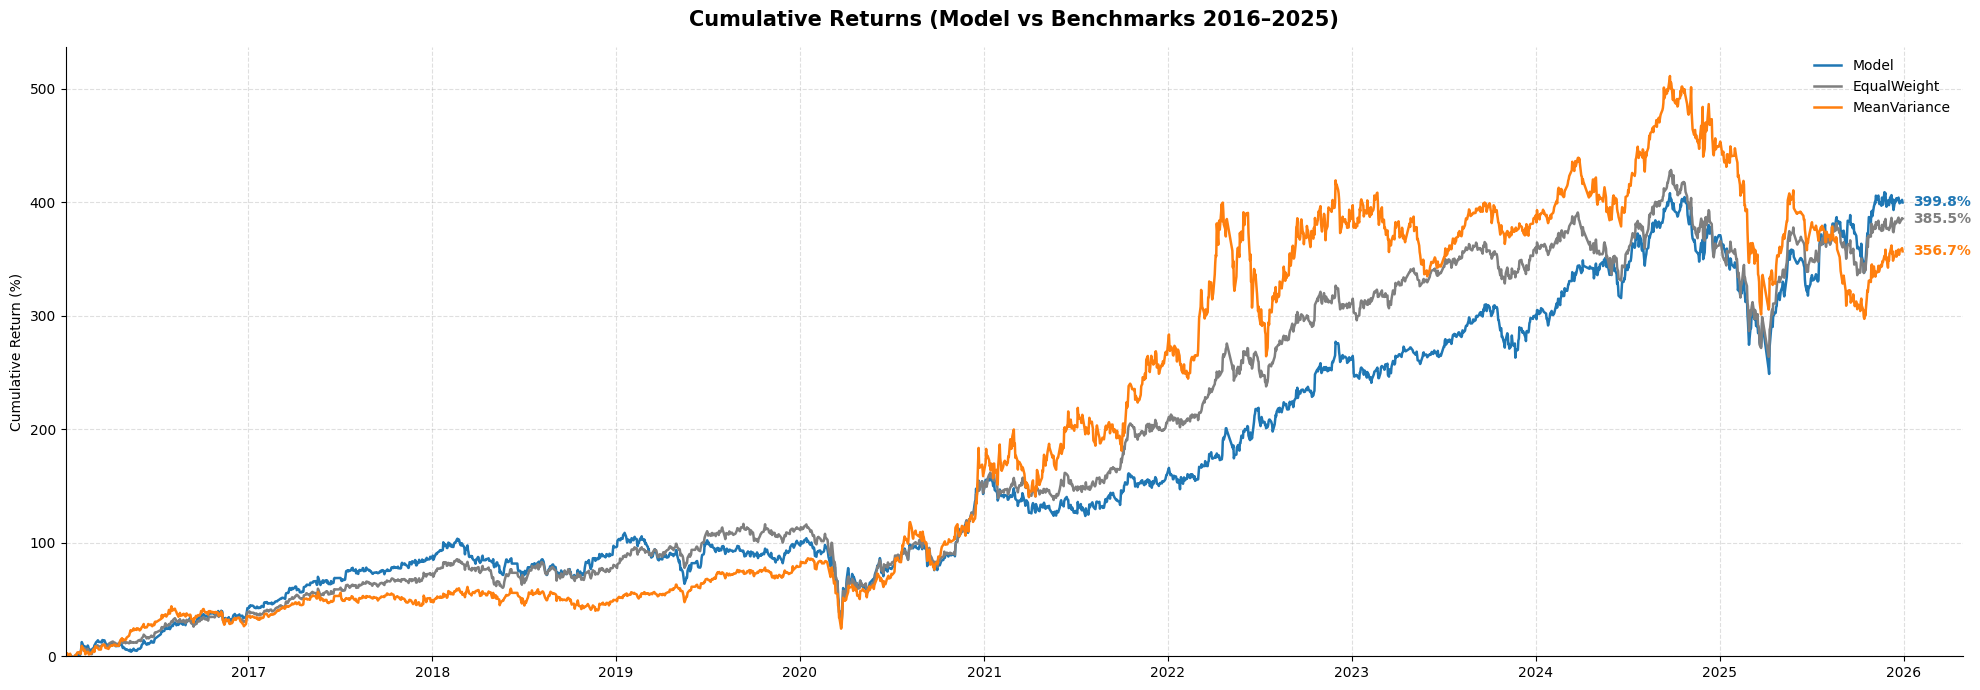

In [9]:
cumulative_returns_pct = (results_df / results_df.iloc[0] - 1) * 100
fig, ax = plt.subplots(figsize=(20, 7))

colors = {
    'Model': '#1f77b4',
    'EqualWeight': '#7f7f7f',
    'MeanVariance': '#ff7f0e'
}

styles = {
    'Model': '-',
    'EqualWeight': '-',
    'MeanVariance': '-'
}

for col in cumulative_returns_pct.columns:
    ax.plot(cumulative_returns_pct.index,cumulative_returns_pct[col],label=col,linewidth=1.8,linestyle=styles[col],color=colors[col])

# y_lines = np.arange(0, 401, 50)

# for y in y_lines:
#     color = 'blue' if y == 0 else 'green'
#     ax.axhline(y,linestyle='--',linewidth=1,alpha=0.5,color=color)

last_x = cumulative_returns_pct.index[-1]
offset = pd.Timedelta(days=20)

for col in cumulative_returns_pct.columns:
    y = cumulative_returns_pct[col].iloc[-1]
    ax.text(last_x + offset,y,f"{y:.1f}%",va='center',fontsize=10,fontweight='bold',color=colors[col])

ax.set_title('Cumulative Returns (Model vs Benchmarks 2016–2025)',fontsize=15,pad=15,fontweight='bold')
ax.set_ylabel('Cumulative Return (%)')
ax.legend(frameon=False)
ax.grid(True, linestyle='--', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(bottom=0)
ax.set_xlim(cumulative_returns_pct.index[0],cumulative_returns_pct.index[-1] + pd.Timedelta(days=120))
plt.tight_layout()
plt.show()

## **Yearly Sharpe Ratio Comparison**

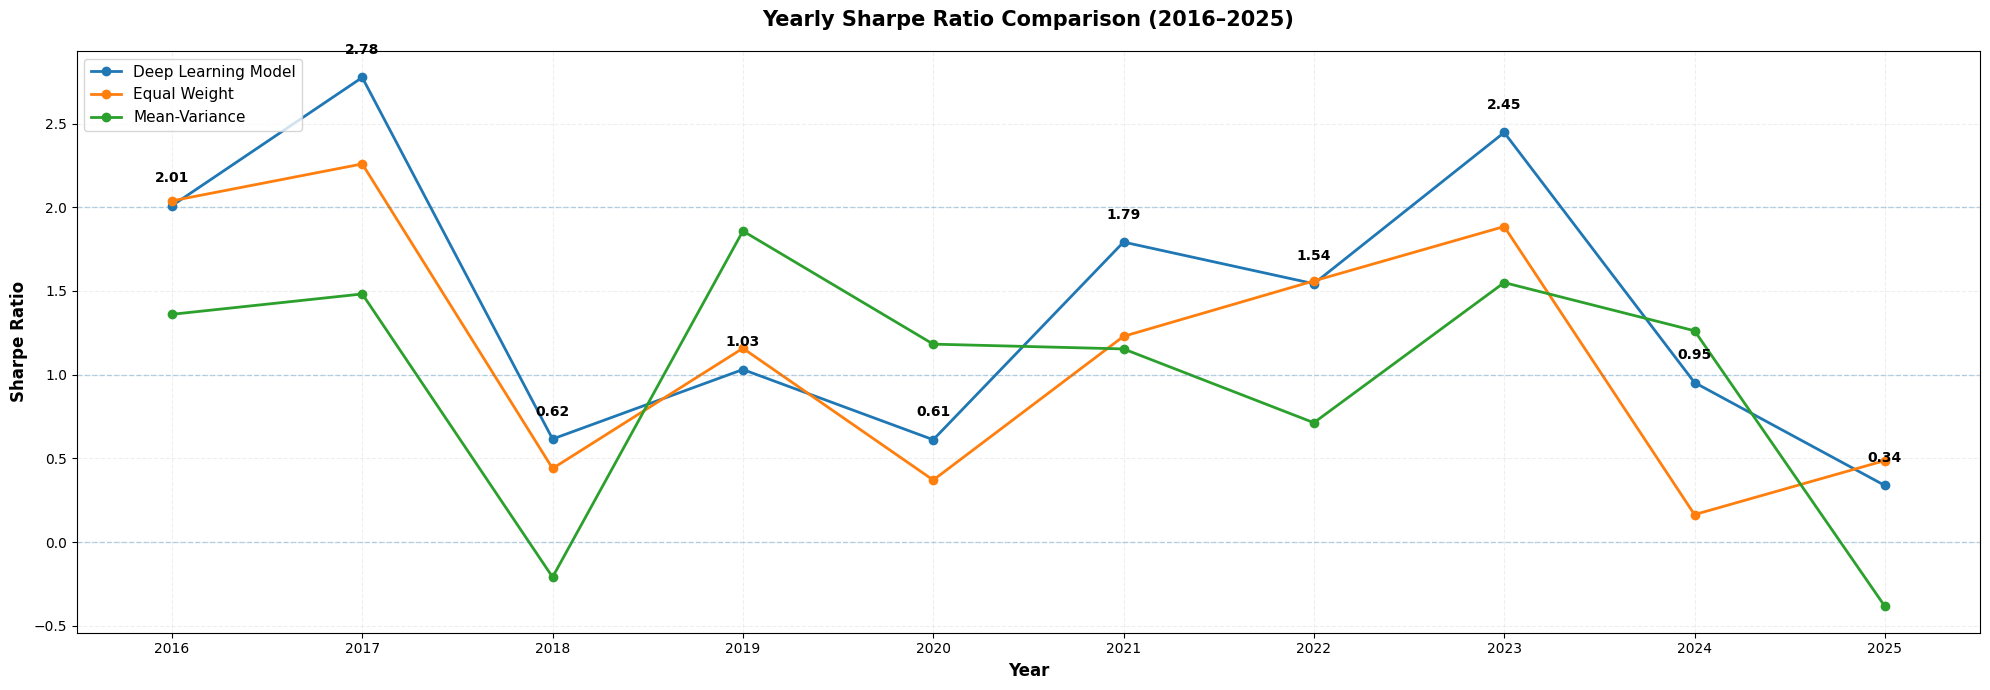

In [ ]:
df_portfolio = pd.DataFrame(portfolio_values, index=dates_history)
df_portfolio.index = pd.to_datetime(df_portfolio.index)
df_daily_returns = df_portfolio.pct_change().dropna()

def calculate_yearly_sharpe(group):
    ann_return = group.mean() * 252
    ann_vol = group.std() * np.sqrt(252)
    return ann_return / (ann_vol + 1e-8)

yearly_sharpe = df_daily_returns.groupby(df_daily_returns.index.year).apply(calculate_yearly_sharpe)
yearly_sharpe = yearly_sharpe.loc[2016:2025]

plt.figure(figsize=(20, 7), facecolor="white")
years = yearly_sharpe.index.astype(int)

plt.plot(years, yearly_sharpe["Model"], marker="o", linewidth=2, label="Deep Learning Model", color="#1f77b4")
plt.plot(years, yearly_sharpe["EqualWeight"], marker="o", linewidth=2, label="Equal Weight", color="#ff7f0e")
plt.plot(years, yearly_sharpe["MeanVariance"], marker="o", linewidth=2, label="Mean-Variance", color="#2ca02c")

y_range = yearly_sharpe["Model"].max() - yearly_sharpe["Model"].min()
offset = y_range * 0.05 if y_range != 0 else 0.1

for x, y in zip(years, yearly_sharpe["Model"]):
    plt.text(x, y + offset, f"{y:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Yearly Sharpe Ratio Comparison (2016–2025)", fontsize=15, fontweight="bold", pad=18)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")

plt.xticks(range(int(min(years)), int(max(years)) + 1))
plt.xlim(min(years) - 0.5, max(years) + 0.5)

for y_line in [0, 1, 2]:
    plt.axhline(y_line, linestyle="--", linewidth=1, alpha=0.3)

plt.legend(frameon=True, fontsize=11, loc="upper left")
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()

## **Yearly Annualized Volatility Comparison**

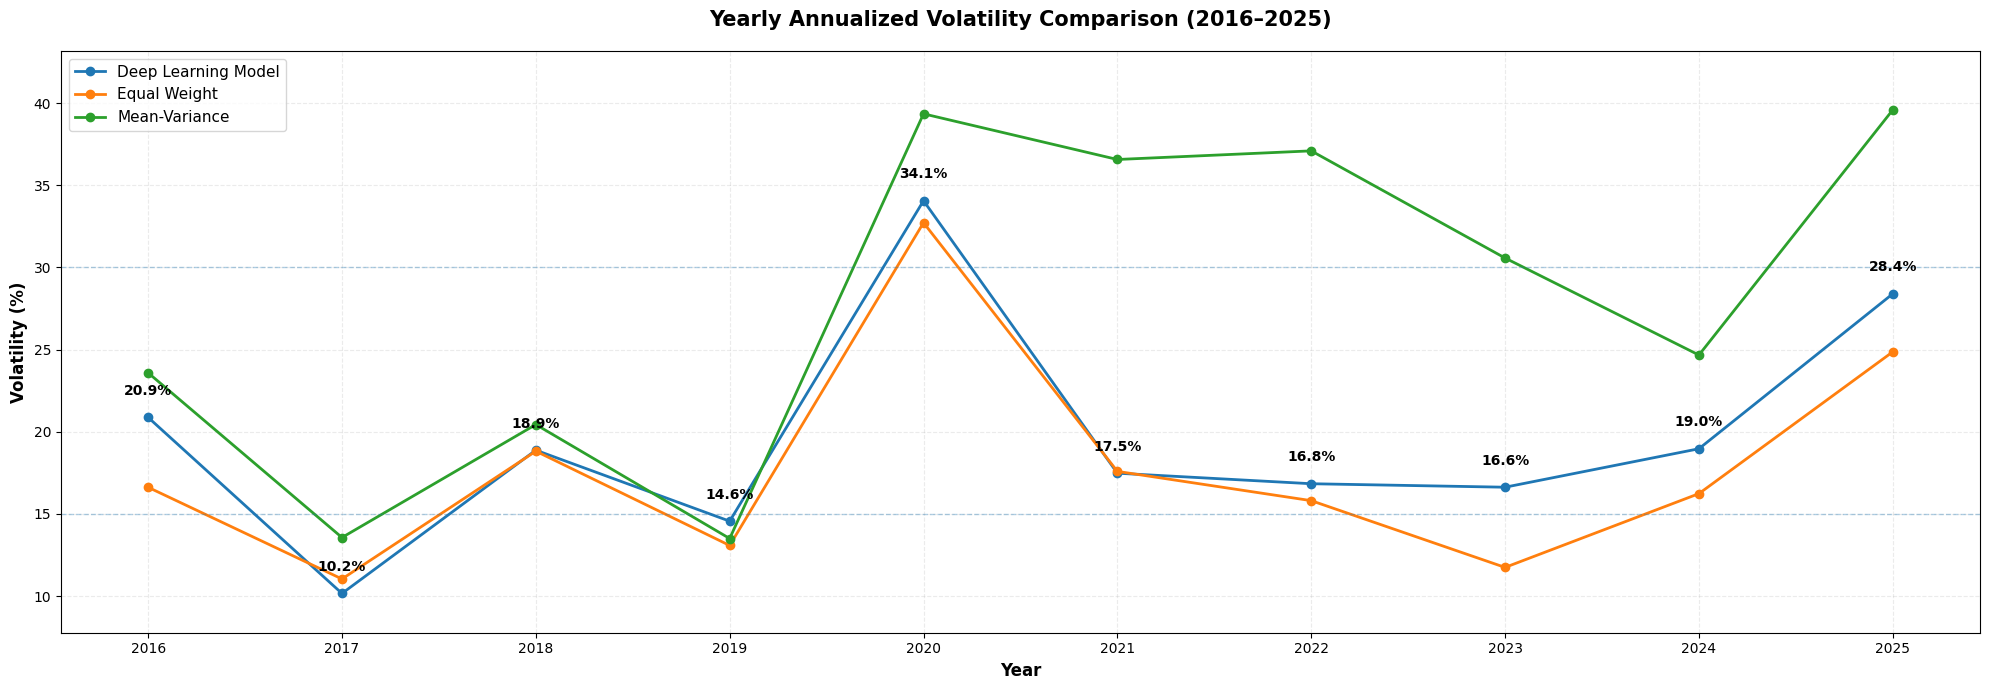

In [ ]:
df_daily_returns = results_df.pct_change().dropna()
yearly_vol = (df_daily_returns.groupby(df_daily_returns.index.year).std()* np.sqrt(252)* 100)
yearly_vol = yearly_vol.loc[2016:2025]
years = yearly_vol.index
plt.figure(figsize=(20, 7), facecolor="white")
plt.plot(years,yearly_vol["Model"],marker="o",linewidth=2,label="Deep Learning Model")
plt.plot(years,yearly_vol["EqualWeight"],marker="o",linewidth=2,label="Equal Weight")
plt.plot(years,yearly_vol["MeanVariance"],marker="o",linewidth=2,label="Mean-Variance")
y_range = yearly_vol["Model"].max() - yearly_vol["Model"].min()
offset = y_range * 0.05 if y_range != 0 else 0.5

for x, y in zip(years, yearly_vol["Model"]):
    plt.text(x,y + offset,f"{y:.1f}%",ha="center",va="bottom",fontsize=10,fontweight="bold")

for y in [15, 30]:
    plt.axhline(y, linestyle="--", linewidth=1, alpha=0.35)

plt.title("Yearly Annualized Volatility Comparison (2016–2025)", fontsize=15, fontweight="bold", pad=18)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")
plt.xticks(years)
plt.ylim(yearly_vol.min().min() - offset * 2,yearly_vol.max().max() + offset * 3)
plt.legend(frameon=True, fontsize=11, loc="upper left")
plt.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()

## **Drawdown Analysis**

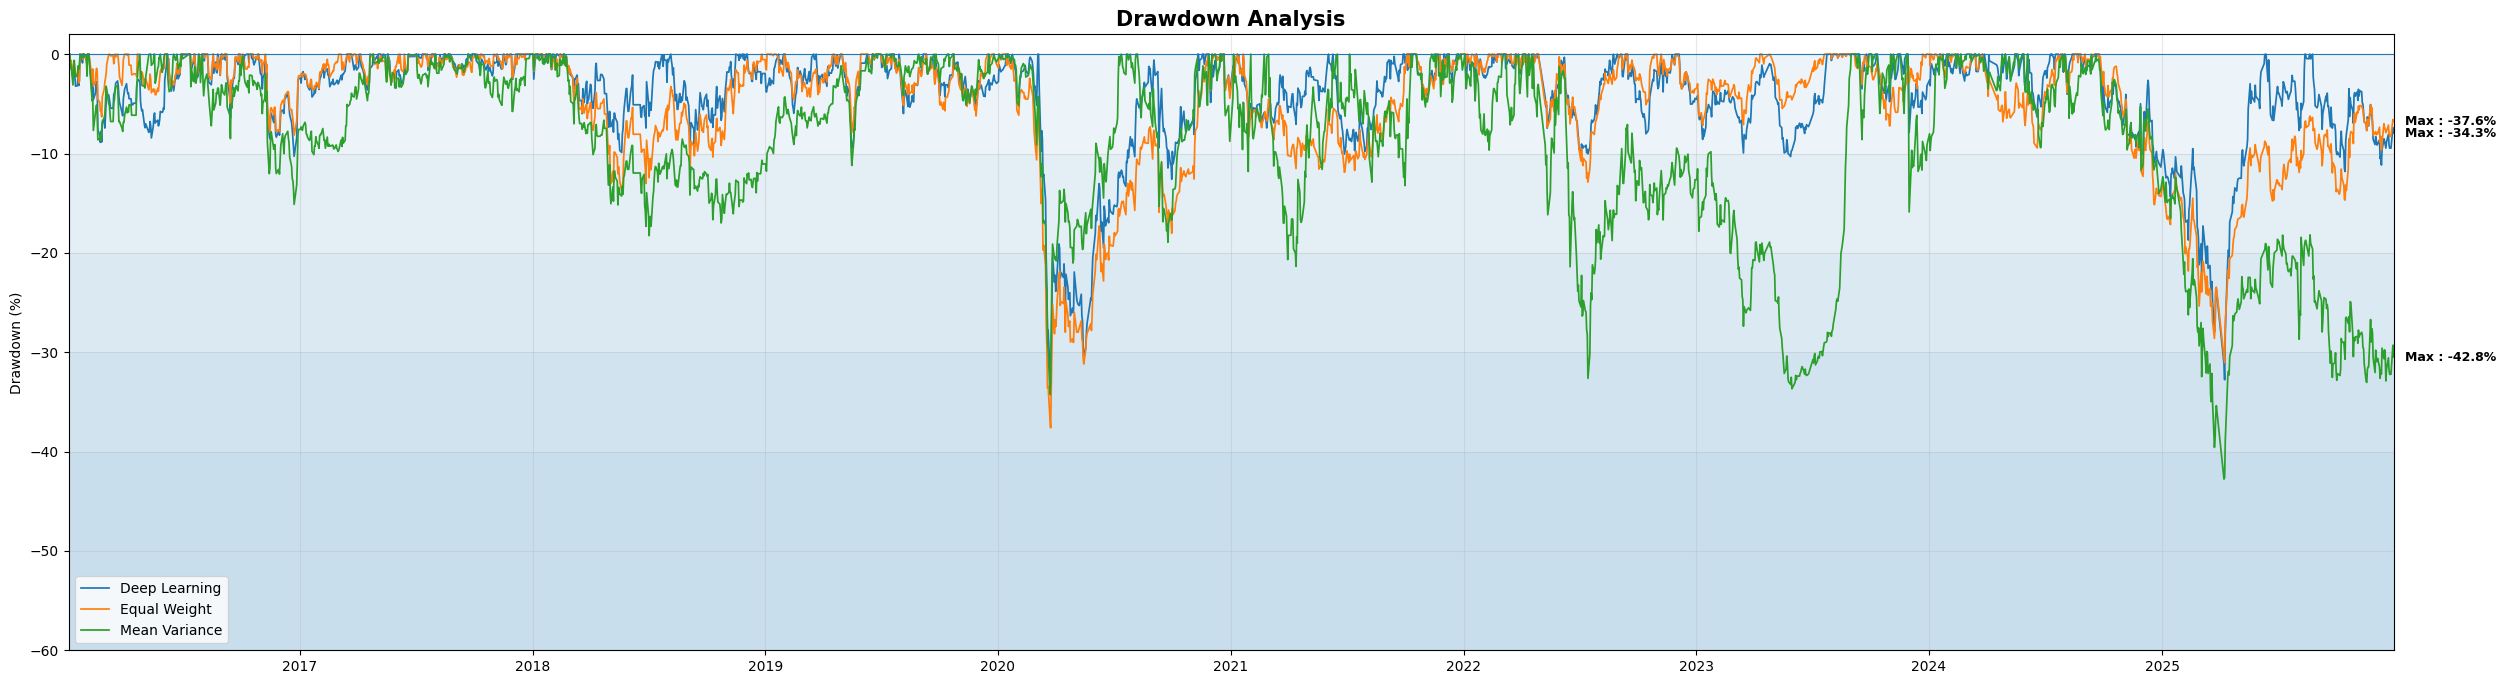

In [ ]:
strategies = {
    "Deep Learning": results_df["Model"],
    "Equal Weight": results_df["EqualWeight"],
    "Mean Variance": results_df["MeanVariance"]
}

fig, ax = plt.subplots(figsize=(30, 8))

ax.axhspan(-10, 0, alpha=0.08)
ax.axhspan(-20, -10, alpha=0.12)
ax.axhspan(-30, -20, alpha=0.16)
ax.axhspan(-40, -30, alpha=0.20)
ax.axhspan(-60, -40, alpha=0.24)

for name, equity in strategies.items():
    rolling_max = equity.cummax()
    drawdown = (equity - rolling_max) / rolling_max * 100
    ax.plot(drawdown.index,drawdown,linewidth=1.25,label=name)
    max_dd = drawdown.min()
    x_last = drawdown.index[-1]
    y_last = drawdown.iloc[-1]
    ax.annotate(f"Max : {max_dd:.1f}%",xy=(x_last, y_last),xytext=(8, 0),textcoords="offset points",va="center",ha="left",fontsize=9,fontweight="bold")

ax.axhline(0, linewidth=0.8)
ax.set_xlim(results_df.index[0], results_df.index[-1])
ax.margins(x=0)
ax.set_title("Drawdown Analysis", fontsize=15, fontweight="bold")
ax.set_ylabel("Drawdown (%)")
ax.set_ylim(-60, 2)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# **Result Deep Learning Model Strategy**

## **Portfolio Allocation per Year**

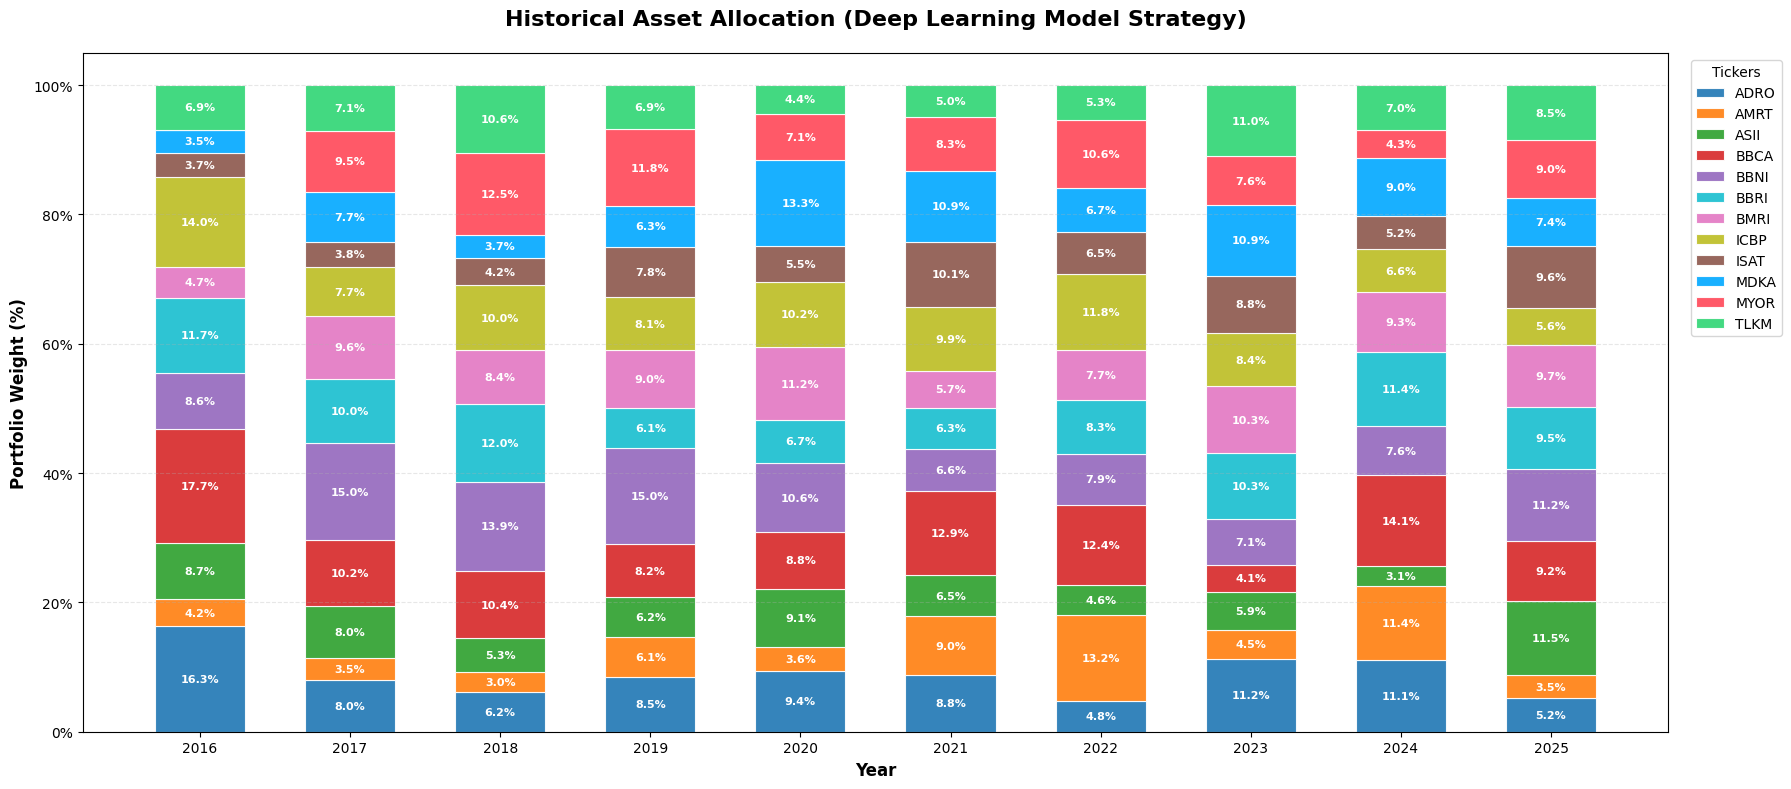

In [12]:
yearly_weights = weights_df.groupby(weights_df.index.year).mean()

# 2. Inisialisasi Plot
fig, ax = plt.subplots(figsize=(18, 8), facecolor="white")
years = yearly_weights.index
bottom = np.zeros(len(years))

# Menggunakan daftar warna yang Anda berikan (Total 12 Warna untuk 12 Saham)
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#17becf', '#e377c2', '#bcbd22', '#8c564b', '#00a8ff',
    '#ff4757', '#2ed573'
]

# 3. Plotting Bar Bertumpuk (Stacked Bar)
for i, ticker in enumerate(TICKERS):
    values = yearly_weights[ticker].values

    # Plot bar untuk setiap saham
    ax.bar(years, values, bottom=bottom, label=ticker.replace(".JK", ""),
           color=colors[i % len(colors)], alpha=0.9, edgecolor="white", linewidth=0.8, width=0.6)

    # Menambahkan label persentase di tengah segmen bar (Hanya jika > 3% agar tidak tumpang tindih)
    for j, val in enumerate(values):
        if val > 0.03:
            ax.text(years[j], bottom[j] + val / 2, f"{val*100:.1f}%",
                    ha="center", va="center", fontsize=8, color="white", fontweight="bold")

    bottom += values

# 4. Styling Grafik
ax.set_title("Historical Asset Allocation (Deep Learning Model Strategy)", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Year", fontsize=12, fontweight="bold")
ax.set_ylabel("Portfolio Weight (%)", fontsize=12, fontweight="bold")

# Format Y-axis menjadi persentase
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

ax.set_ylim(0, 1.05)
ax.set_xticks(years)
ax.legend(title="Tickers", bbox_to_anchor=(1.01, 1), loc="upper left", frameon=True, fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

## **Annualized Return per Year**

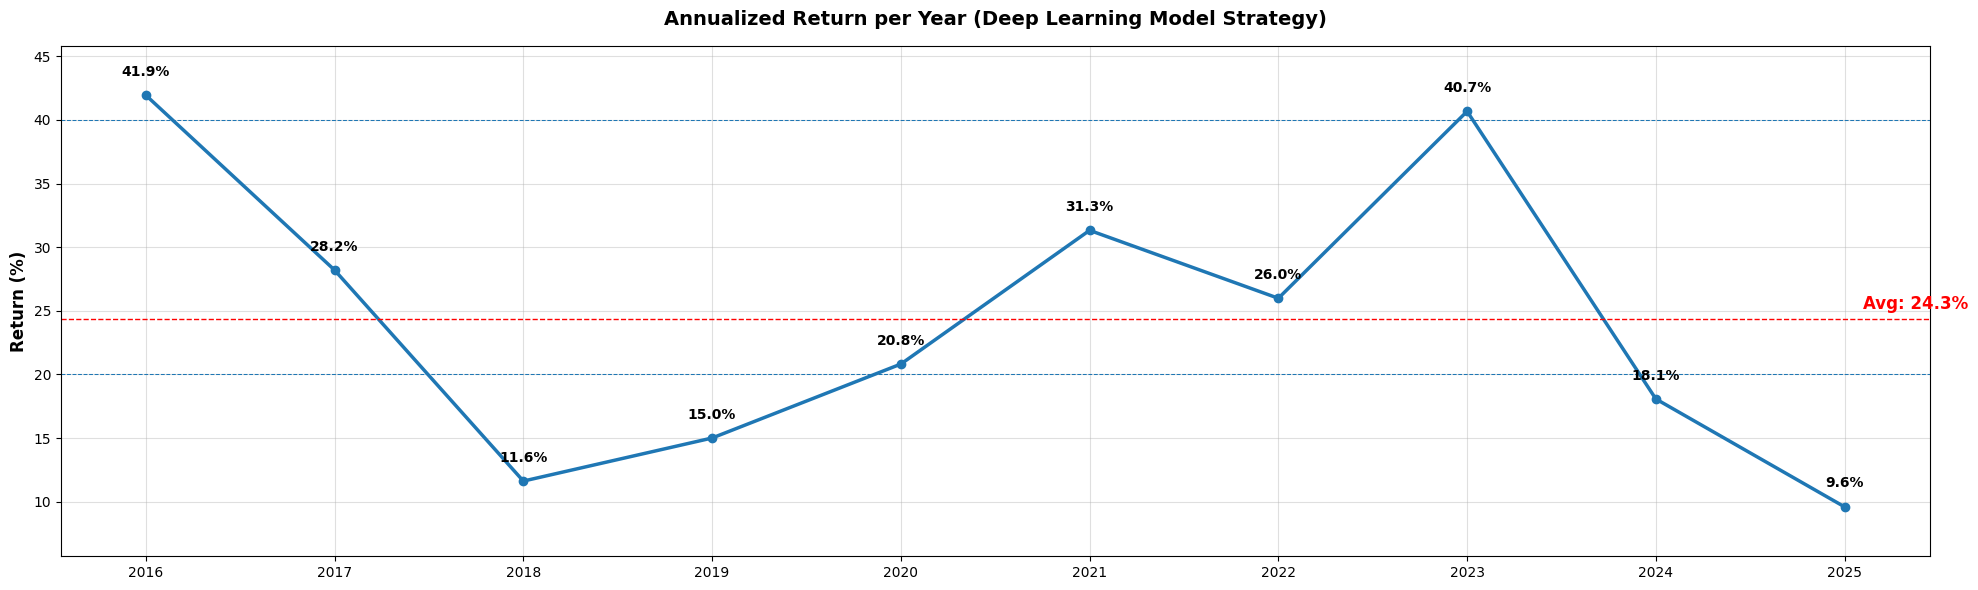

In [ ]:
daily_rets_sim = results_df.pct_change().dropna()
yearly_ann_return = daily_rets_sim.groupby(daily_rets_sim.index.year).mean() * 252
yearly_ann_vol = daily_rets_sim.groupby(daily_rets_sim.index.year).std() * np.sqrt(252)
yearly_ann_sharpe = yearly_ann_return / yearly_ann_vol
years = yearly_ann_return.index
values = yearly_ann_return["Model"] * 100
plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#1f77b4')
y_range = values.max() - values.min()
offset = y_range * 0.04 if y_range != 0 else 0.5

for x, y in zip(years, values):
    va = "bottom" if y >= 0 else "top"
    y_text = y + offset if y >= 0 else y - offset
    plt.text(x, y_text, f"{y:.1f}%", ha="center", va=va, fontsize=10, fontweight="bold")

avg_return = values.mean()
plt.axhline(avg_return, color='red', linestyle='--', linewidth=1)
offset_label = 0.5
plt.text(years[-1] + 0.1, avg_return + offset_label, f'Avg: {avg_return:.1f}%', color='red', va='bottom', fontsize=12, fontweight="bold")
plt.title("Annualized Return per Year (Deep Learning Model Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Return (%)", fontsize=12, fontweight="bold")

for y in [-20, 0, 20, 40]:
    plt.axhline(y, linewidth=0.75, linestyle="--")

plt.xticks(years)
plt.ylim(values.min() - offset * 3, values.max() + offset * 3)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

## **Annualized Volatility per Year**

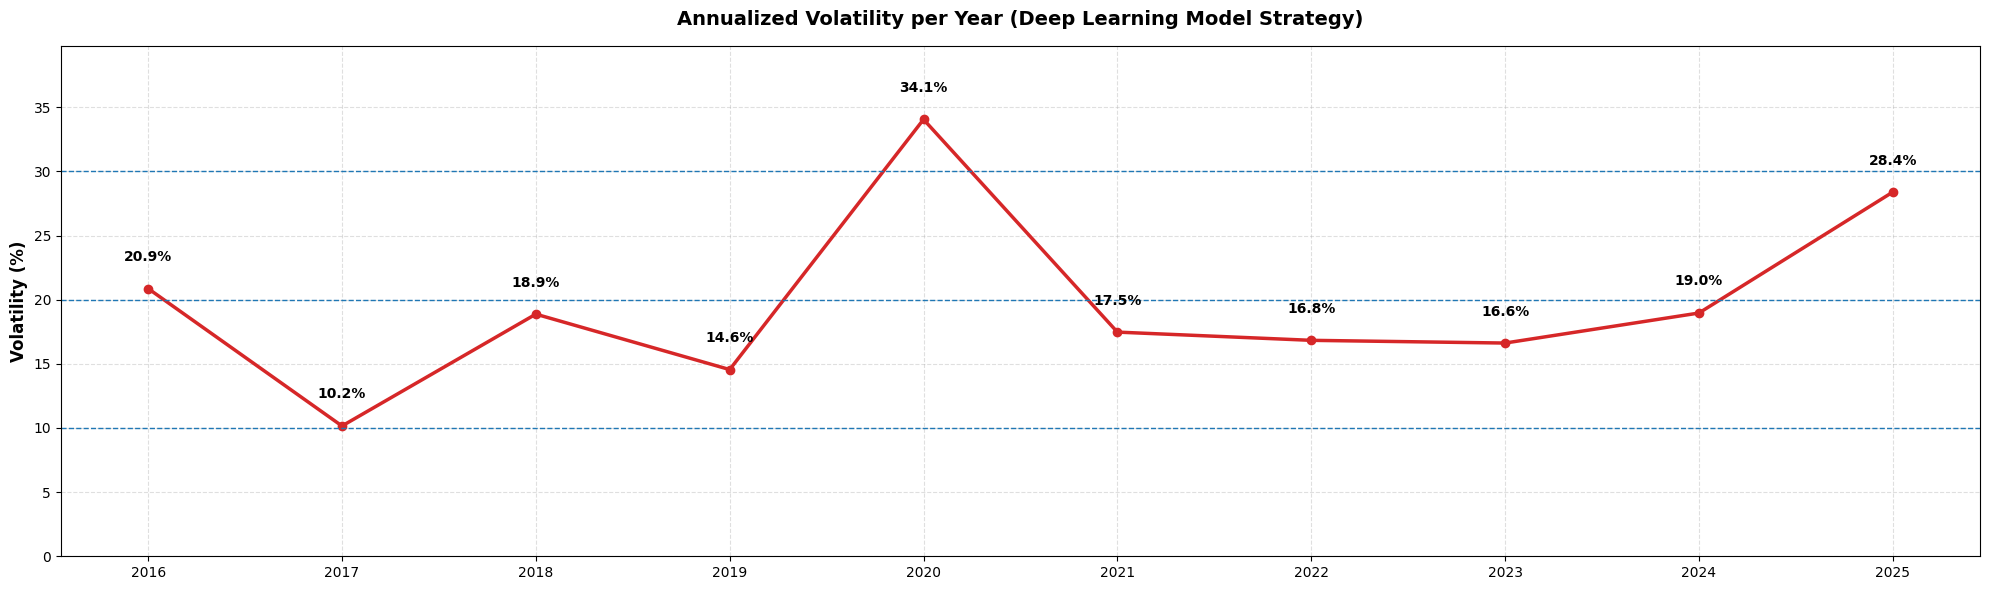

In [ ]:
values = yearly_ann_vol["Model"] * 100
plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#d62728')
y_range = values.max() - values.min()
offset = y_range * 0.08 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x, y + offset, f"{y:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Annualized Volatility per Year (Deep Learning Model Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")

for y in [10, 20, 30]:
    plt.axhline(y, linewidth=1, linestyle="--")

plt.xticks(years)
plt.ylim(0, values.max() + offset * 3)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## **Annualized Sharpe Ratio**

0 = Break even

1 = Good

2 = Very Good

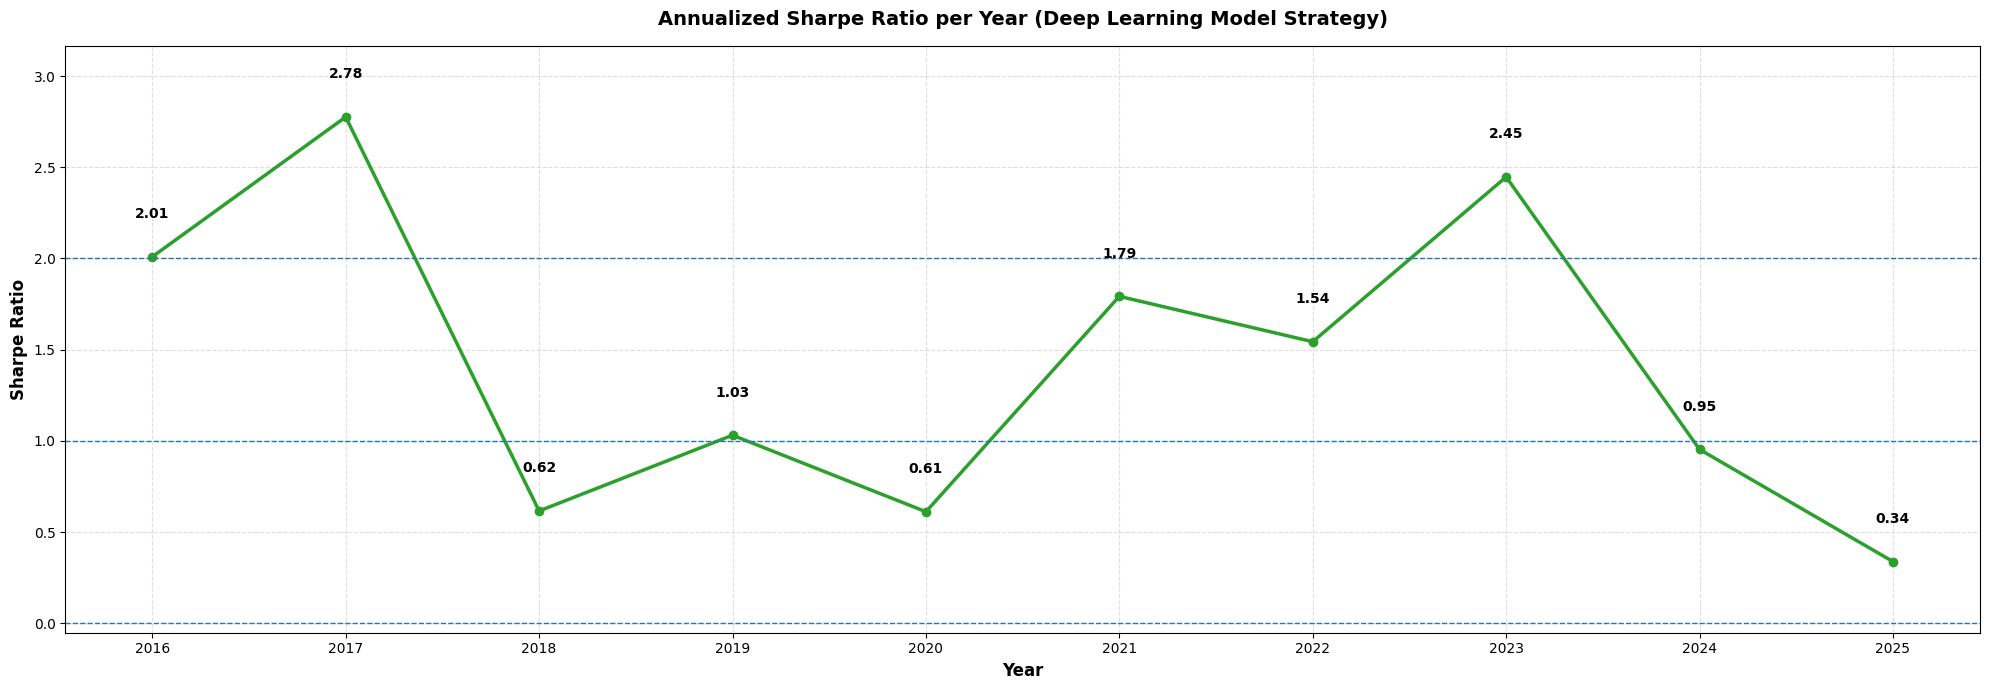

In [ ]:
values = yearly_ann_sharpe["Model"]
plt.figure(figsize=(20, 7), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#2ca02c')
y_range = values.max() - values.min()
offset = y_range * 0.08 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x, y + offset, f"{y:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Annualized Sharpe Ratio per Year (Deep Learning Model Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")

for y in [-1, 0, 1, 2]:
    plt.axhline(y, linewidth=1, linestyle="--")

plt.xticks(years)
plt.ylim(values.min() - offset * 2, values.max() + offset * 2)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# **Result Equal Weight Strategy**

## **Portfolio Allocation per Year**

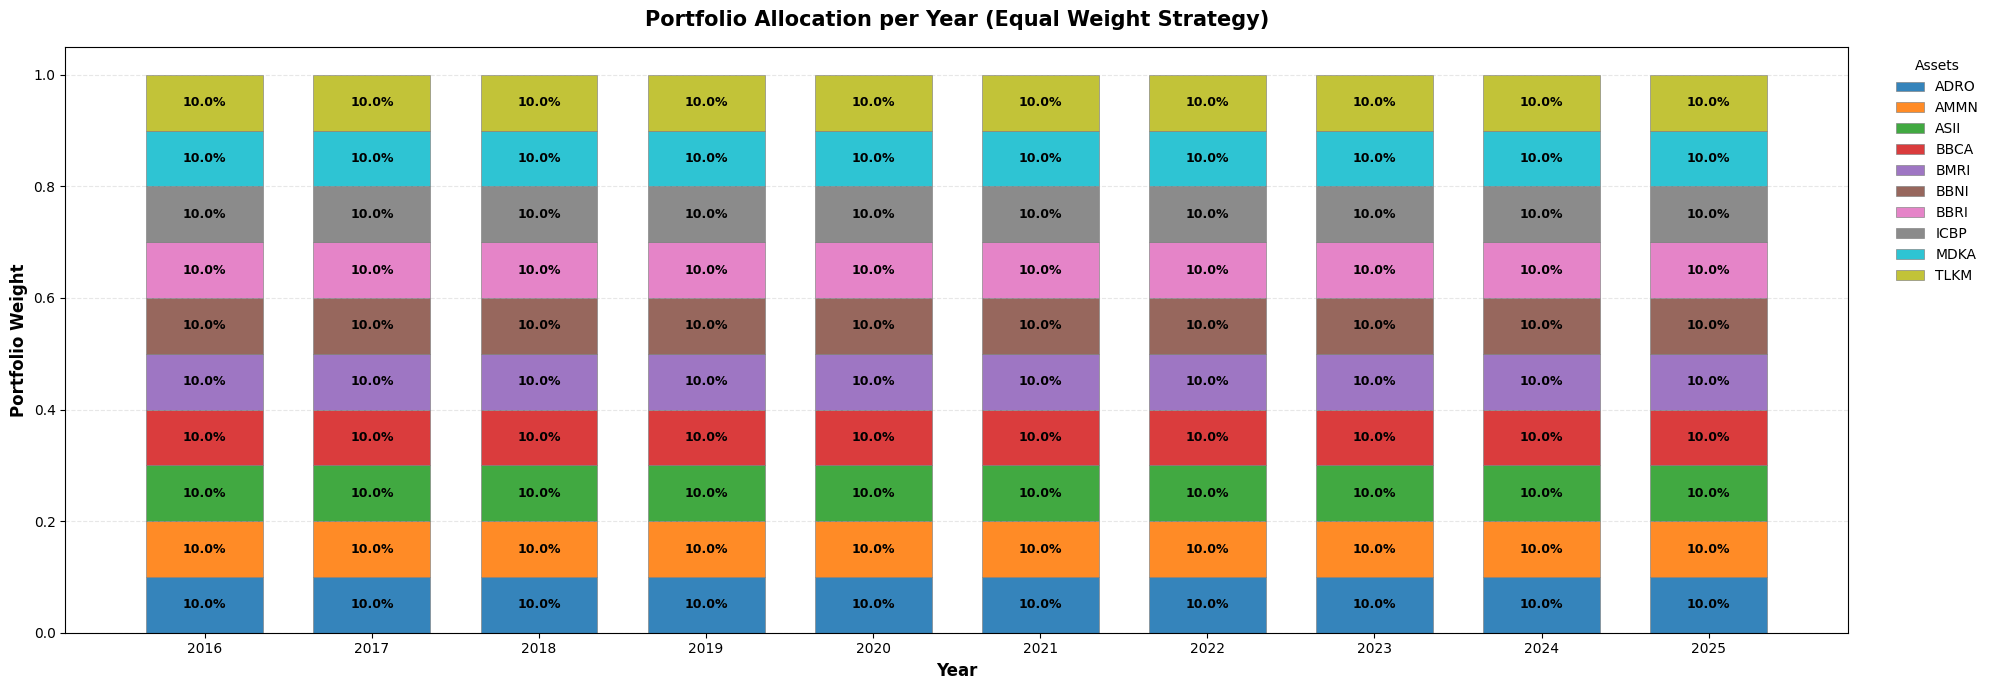

In [ ]:
num_assets = len(TICKERS)
equal_weight = 1.0 / num_assets
years = yearly_weights.index
ew_weights_data = {ticker.replace(".JK", ""): [equal_weight] * len(years)for ticker in TICKERS}
yearly_ew_weights = pd.DataFrame(ew_weights_data, index=years)
fig, ax = plt.subplots(figsize=(20, 7), facecolor="white")
bottom = np.zeros(len(years))
colors_bar = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#17becf', '#bcbd22']

for i, ticker in enumerate(TICKERS):
    ticker_name = ticker.replace(".JK", "")
    values = yearly_ew_weights[ticker_name].values
    ax.bar(years,values,bottom=bottom,label=ticker_name,color=colors_bar[i],alpha=0.9,edgecolor="grey",linewidth=0.5,width=0.7)

    for j, val in enumerate(values):
        ax.text(years[j],bottom[j] + val / 2,f"{val*100:.1f}%",ha="center",va="center",fontsize=9,fontweight="bold")

    bottom += values.astype(float)

ax.set_title("Portfolio Allocation per Year (Equal Weight Strategy)",fontsize=15,fontweight="bold",pad=15)
ax.set_xlabel("Year", fontsize=12, fontweight="bold")
ax.set_ylabel("Portfolio Weight", fontsize=12, fontweight="bold")
ax.set_ylim(0, 1.05)
ax.set_xticks(years)
ax.legend(title="Assets",bbox_to_anchor=(1.02, 1),loc="upper left",frameon=False)
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## **Annualized Return per Year**

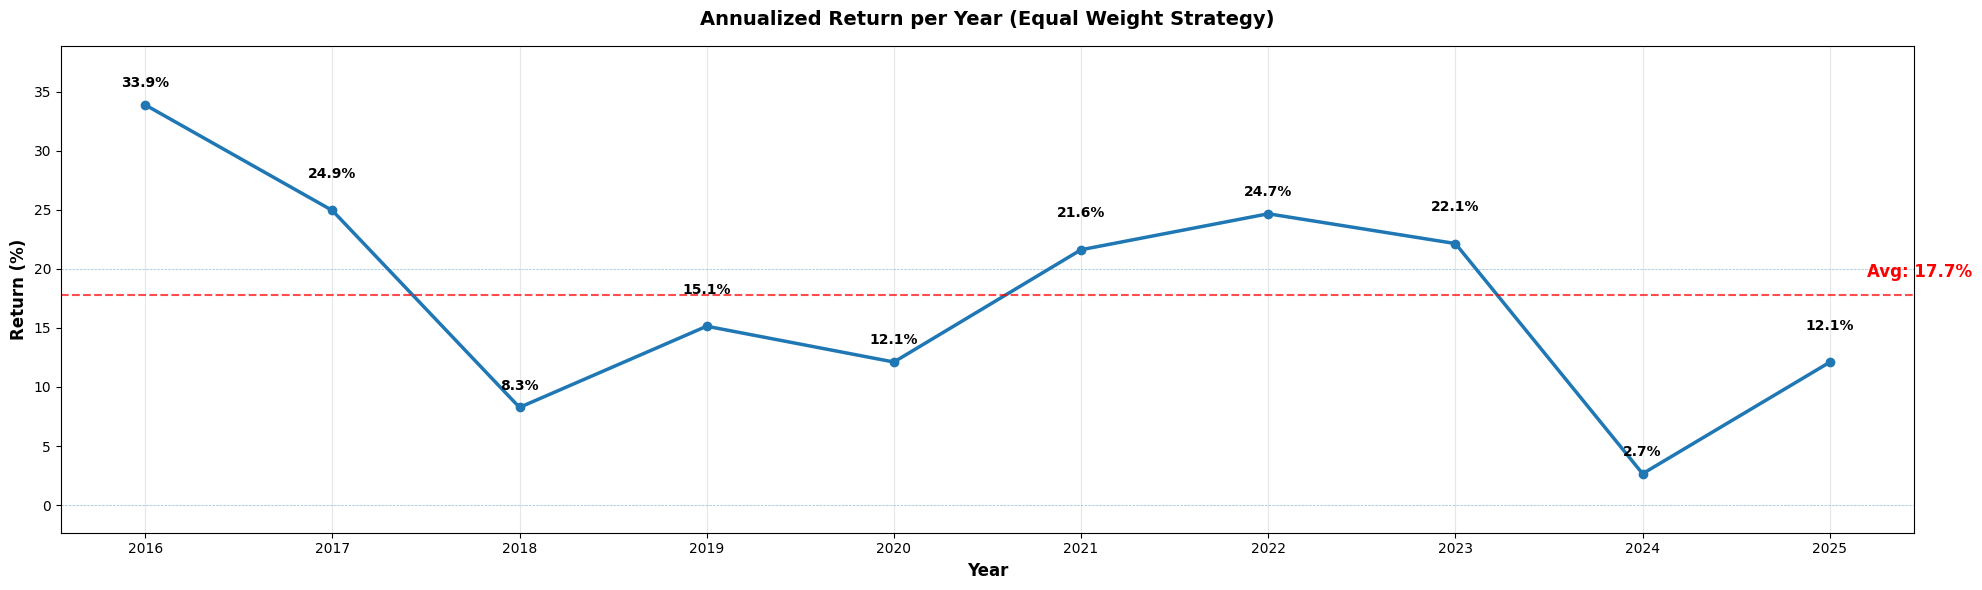

In [ ]:
values_ew = yearly_ann_return["EqualWeight"] * 100
plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values_ew, marker="o", linewidth=2.5, color='#1f77b4', label="Equal Weight")
y_range_ew = values_ew.max() - values_ew.min()
offset_ew = y_range_ew * 0.04 if y_range_ew != 0 else 0.5

for i, (x, y) in enumerate(zip(years, values_ew)):
    va = "bottom" if y >= 0 else "top"
    shift = offset_ew if i % 2 == 0 else offset_ew * 2
    y_text = y + shift if y >= 0 else y - shift
    plt.text(x, y_text, f"{y:.1f}%", ha="center", va=va, fontsize=10, fontweight="bold")

avg_return_ew = values_ew.mean()
plt.axhline(avg_return_ew, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
plt.text(years[-1] + 0.2, avg_return_ew + offset_ew, f'Avg: {avg_return_ew:.1f}%', color='red', va='bottom', fontsize=12, fontweight="bold")
plt.title("Annualized Return per Year (Equal Weight Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Return (%)", fontsize=12, fontweight="bold")
plt.xlabel("Year", fontsize=12, fontweight="bold")

for y_line in [-20, 0, 20, 40, 60]:
    plt.axhline(y_line, linewidth=0.5, linestyle="--", alpha=0.5)

plt.xticks(years)
plt.ylim(values_ew.min() - offset_ew * 4, values_ew.max() + offset_ew * 4)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## **Annualized Volatility per Year**

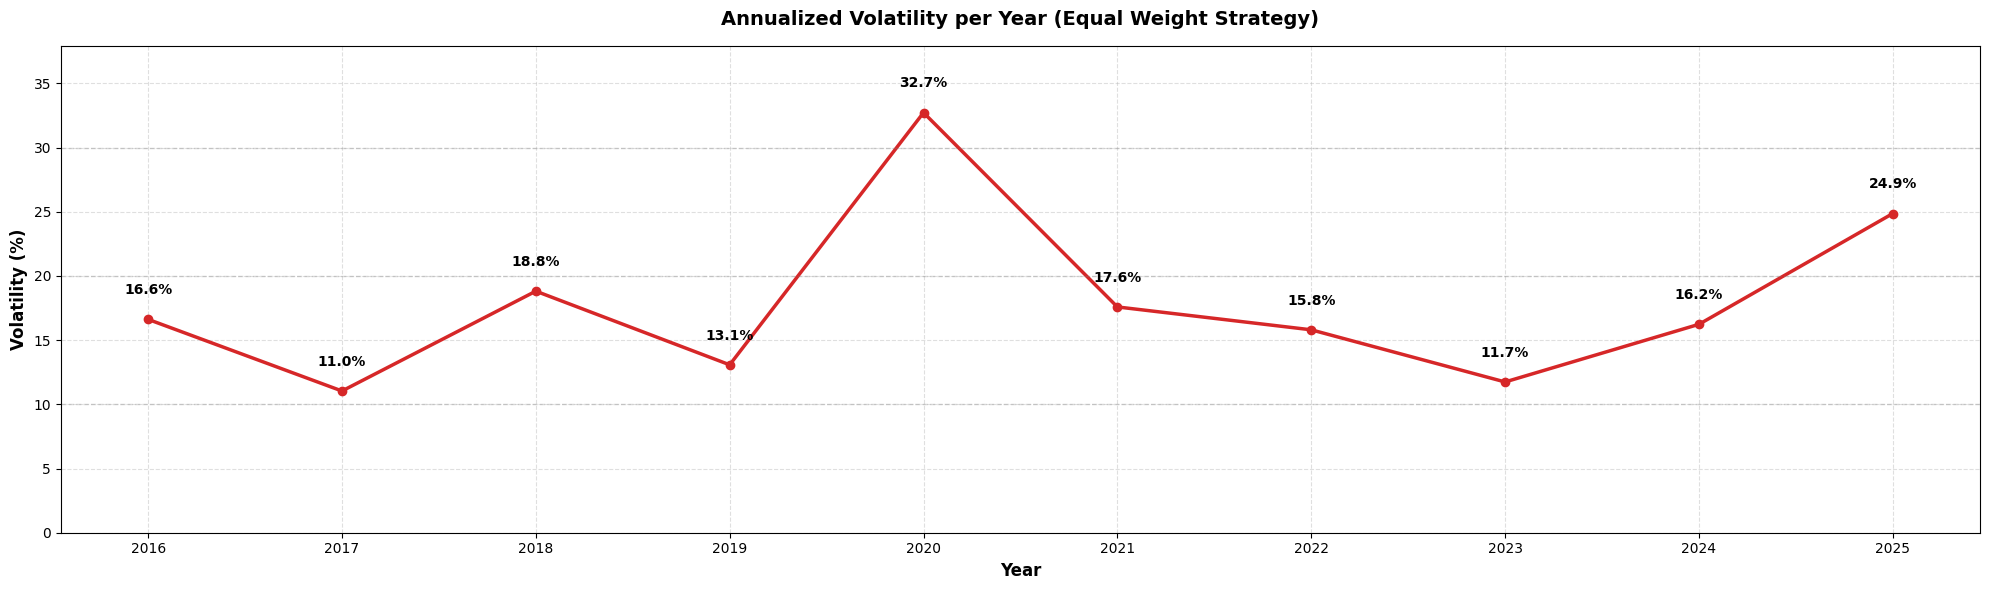

In [ ]:
values_vol_ew = yearly_ann_vol["EqualWeight"] * 100
plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values_vol_ew, marker="o", linewidth=2.5, color='#d62728', label="Equal Weight")
y_range_vol = values_vol_ew.max() - values_vol_ew.min()
offset_vol = y_range_vol * 0.08 if y_range_vol != 0 else 0.5

for x, y in zip(years, values_vol_ew):
    plt.text(x, y + offset_vol, f"{y:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Annualized Volatility per Year (Equal Weight Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")
plt.xlabel("Year", fontsize=12, fontweight="bold")

for y_line in [10, 20, 30, 40]:
    plt.axhline(y_line, linewidth=1, linestyle="--", color='grey', alpha=0.3)

plt.xticks(years)
plt.ylim(0, values_vol_ew.max() + offset_vol * 3)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## **Annualized Sharpe Ratio**

0 = Break even

1 = Good

2 = Very Good

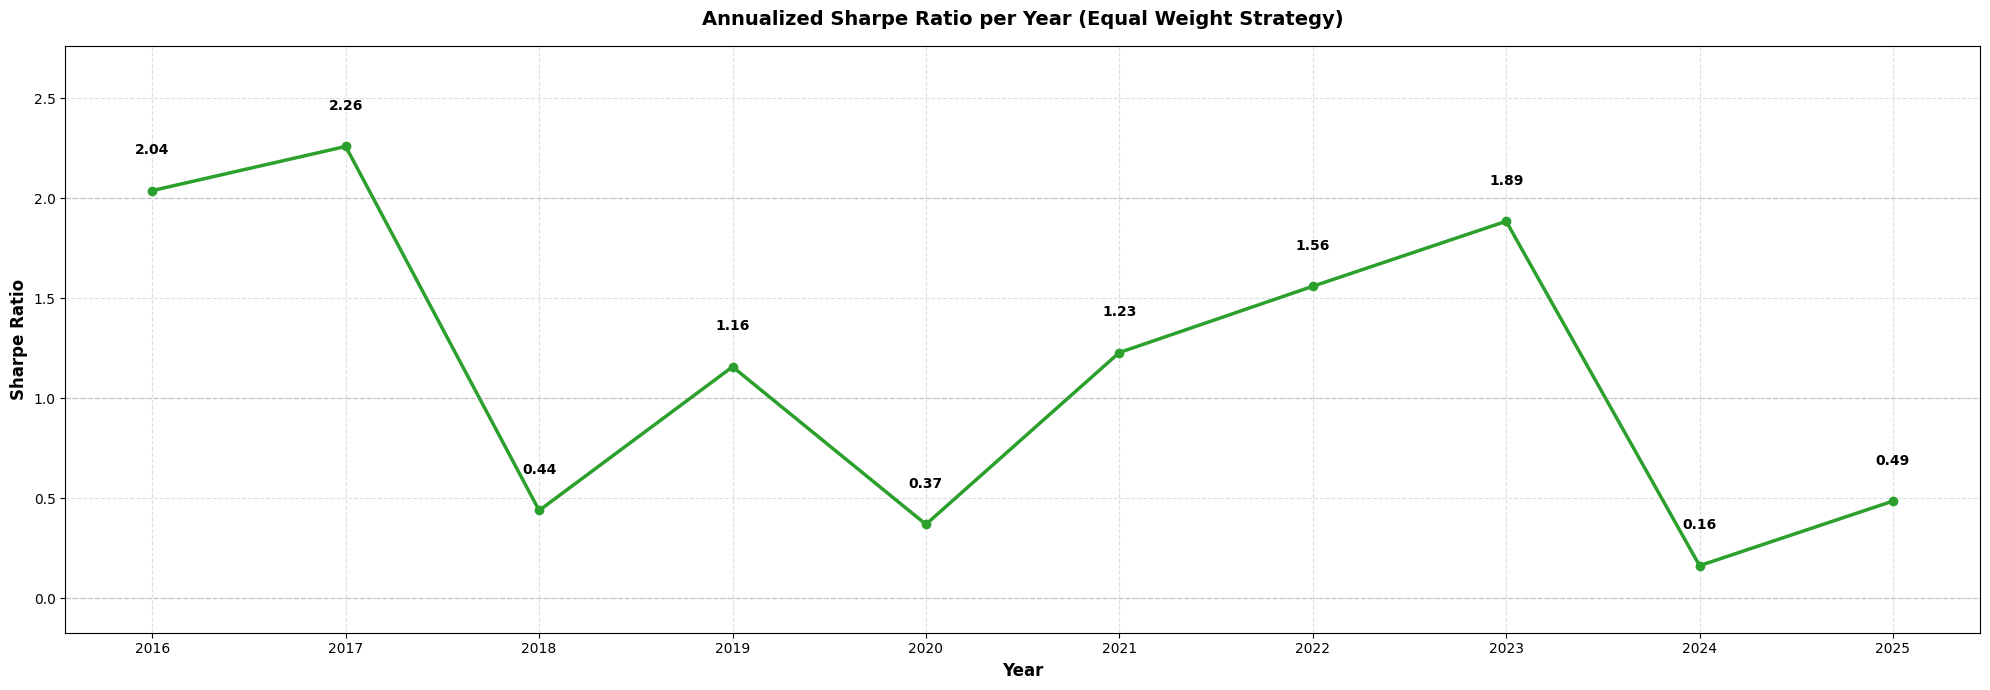

In [ ]:
values_sharpe_ew = yearly_ann_sharpe["EqualWeight"]
plt.figure(figsize=(20, 7), facecolor="white")
plt.plot(years, values_sharpe_ew, marker="o", linewidth=2.5, color='#2ca02c', label="Equal Weight")
y_range_sharpe = values_sharpe_ew.max() - values_sharpe_ew.min()
offset_sharpe = y_range_sharpe * 0.08 if y_range_sharpe != 0 else 0.1

for x, y in zip(years, values_sharpe_ew):
    plt.text(x, y + offset_sharpe, f"{y:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Annualized Sharpe Ratio per Year (Equal Weight Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")

for y_line in [-1, 0, 1, 2]:
    plt.axhline(y_line, linewidth=1, linestyle="--", color='grey', alpha=0.3)

plt.xticks(years)
plt.ylim(values_sharpe_ew.min() - offset_sharpe * 2, values_sharpe_ew.max() + offset_sharpe * 3)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# **Result Mean Variance Strategy**

## **Portfolio Allocation per Year**

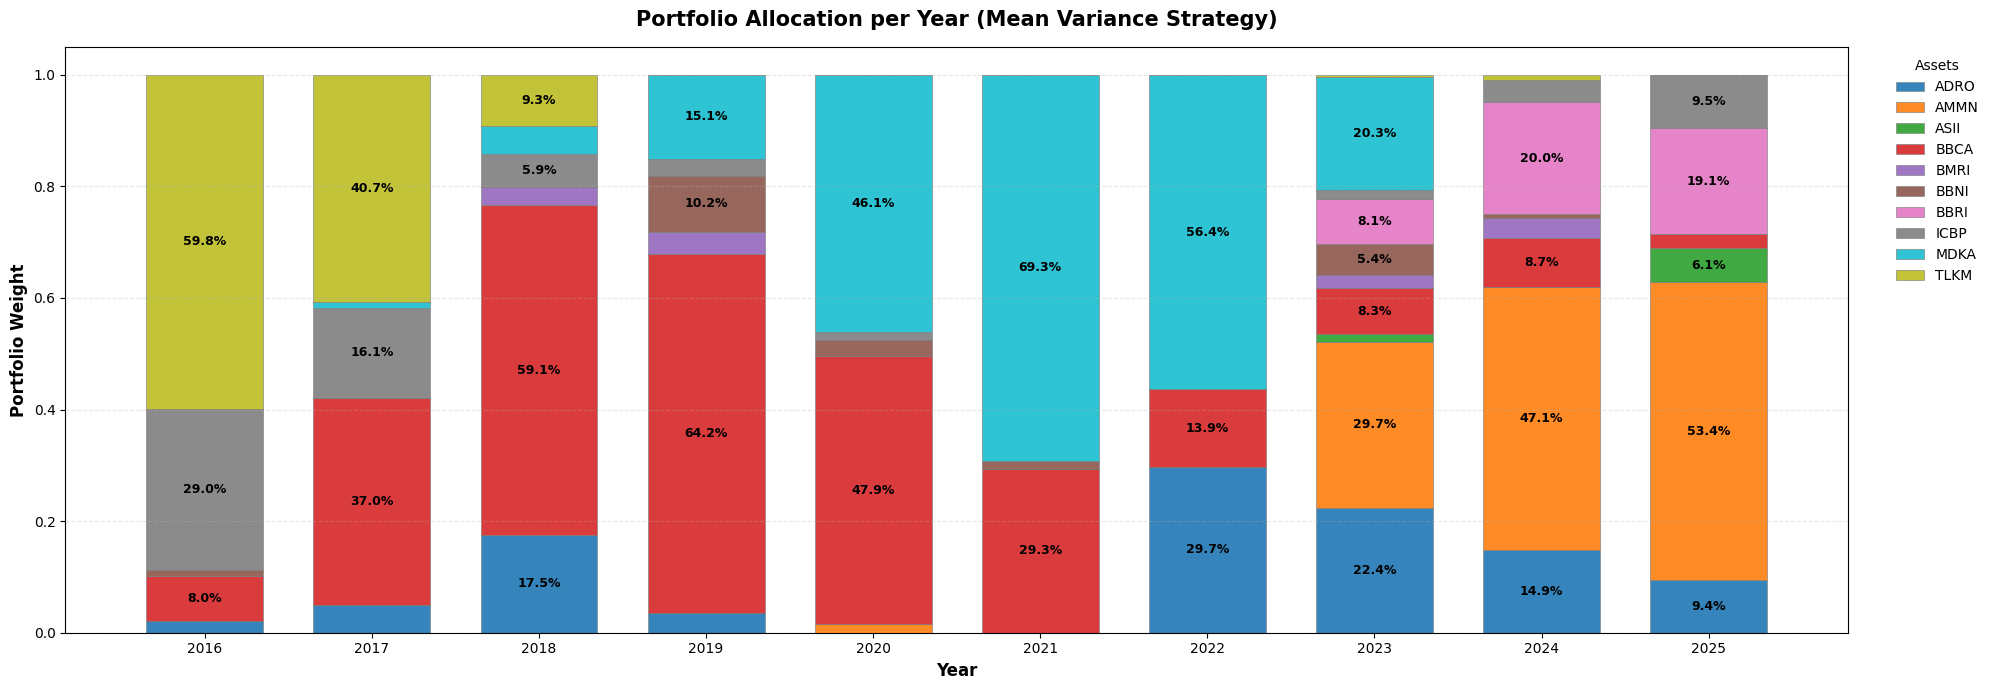

In [ ]:
mv_weights_df = pd.DataFrame(mv_weights_history,index=dates_history,columns=[t.replace(".JK", "") for t in TICKERS])
yearly_mv_weights = mv_weights_df.groupby(mv_weights_df.index.year).mean()
fig, ax = plt.subplots(figsize=(20, 7), facecolor="white")
years = yearly_mv_weights.index
bottom = np.zeros(len(years))
colors_bar = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#17becf', '#bcbd22']

for i, ticker in enumerate(TICKERS):
    name = ticker.replace(".JK", "")
    values = yearly_mv_weights[name].values
    ax.bar(years,values,bottom=bottom,label=name,color=colors_bar[i],alpha=0.9,edgecolor="grey",linewidth=0.5,width=0.7)

    for j, val in enumerate(values):
        if val > 0.05:
            ax.text(years[j],bottom[j] + val / 2,f"{val*100:.1f}%",ha="center",va="center",fontsize=9,fontweight="bold")

    bottom += values.astype(float)

ax.set_title("Portfolio Allocation per Year (Mean Variance Strategy)",fontsize=15,fontweight="bold",pad=15)
ax.set_xlabel("Year", fontsize=12, fontweight="bold")
ax.set_ylabel("Portfolio Weight", fontsize=12, fontweight="bold")
ax.set_ylim(0, 1.05)
ax.set_xticks(years)
ax.legend(title="Assets",bbox_to_anchor=(1.02, 1),loc="upper left",frameon=False)
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## **Annualized Return per Year**

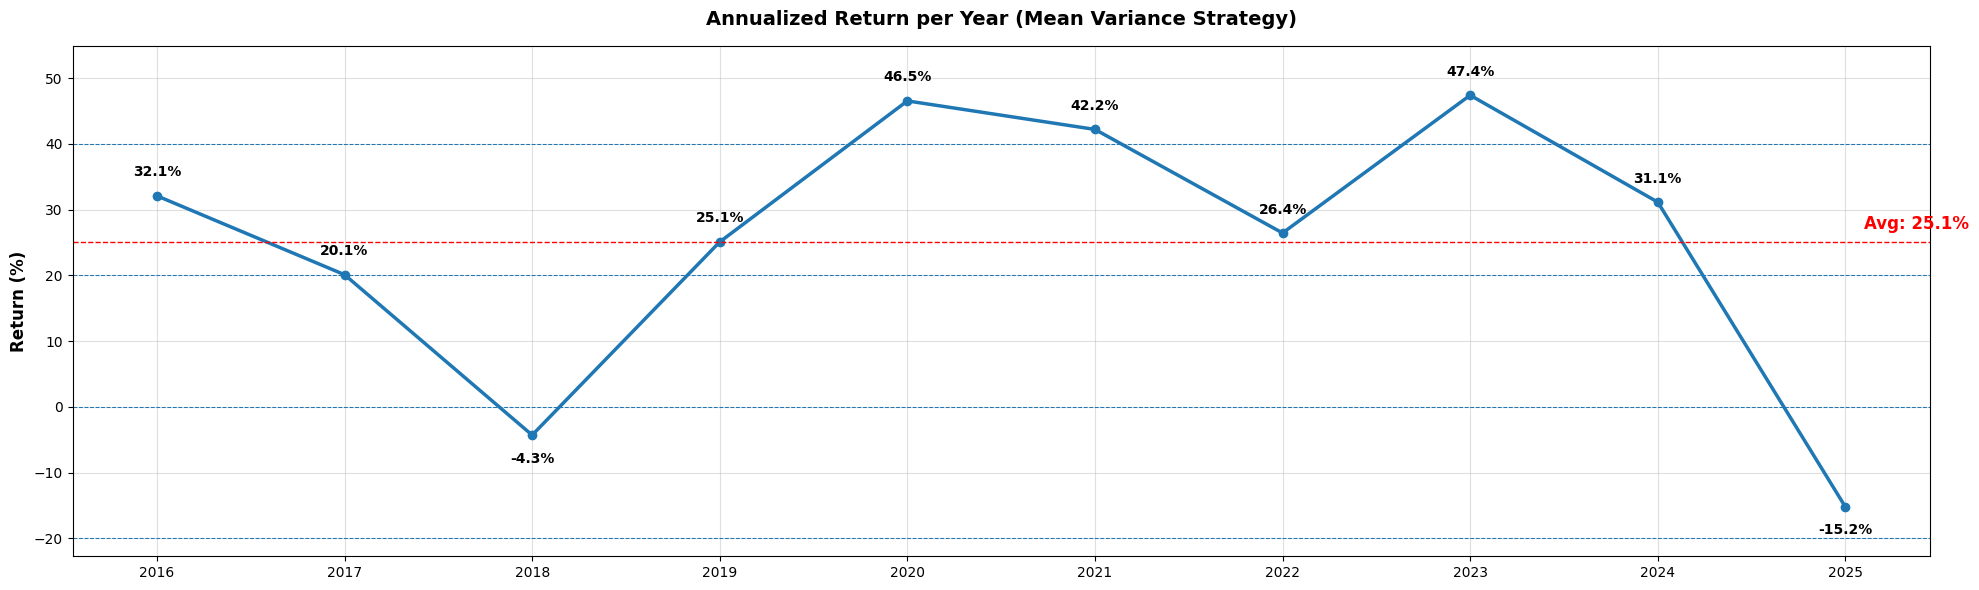

In [ ]:
daily_rets_sim = results_df.pct_change().dropna()
yearly_ann_return = daily_rets_sim.groupby(daily_rets_sim.index.year).mean() * 252
yearly_ann_vol = daily_rets_sim.groupby(daily_rets_sim.index.year).std() * np.sqrt(252)
yearly_ann_sharpe = yearly_ann_return / yearly_ann_vol
years = yearly_ann_return.index
values = yearly_ann_return["MeanVariance"] * 100
plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#1f77b4')
y_range = values.max() - values.min()
offset = y_range * 0.04 if y_range != 0 else 0.5

for x, y in zip(years, values):
    va = "bottom" if y >= 0 else "top"
    y_text = y + offset if y >= 0 else y - offset
    plt.text(x, y_text, f"{y:.1f}%", ha="center", va=va, fontsize=10, fontweight="bold")

avg_return = values.mean()
plt.axhline(avg_return, color='red', linestyle='--', linewidth=1)
offset_label = y_range * 0.02
plt.text(years[-1] + 0.1, avg_return + offset_label, f'Avg: {avg_return:.1f}%', color='red', va='bottom', fontsize=12, fontweight="bold")
plt.title("Annualized Return per Year (Mean Variance Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Return (%)", fontsize=12, fontweight="bold")

for y in [-20, 0, 20, 40]:
    plt.axhline(y, linewidth=0.75, linestyle="--")

plt.xticks(years)
plt.ylim(values.min() - offset * 3, values.max() + offset * 3)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

## **Annualized Volatility per Year**

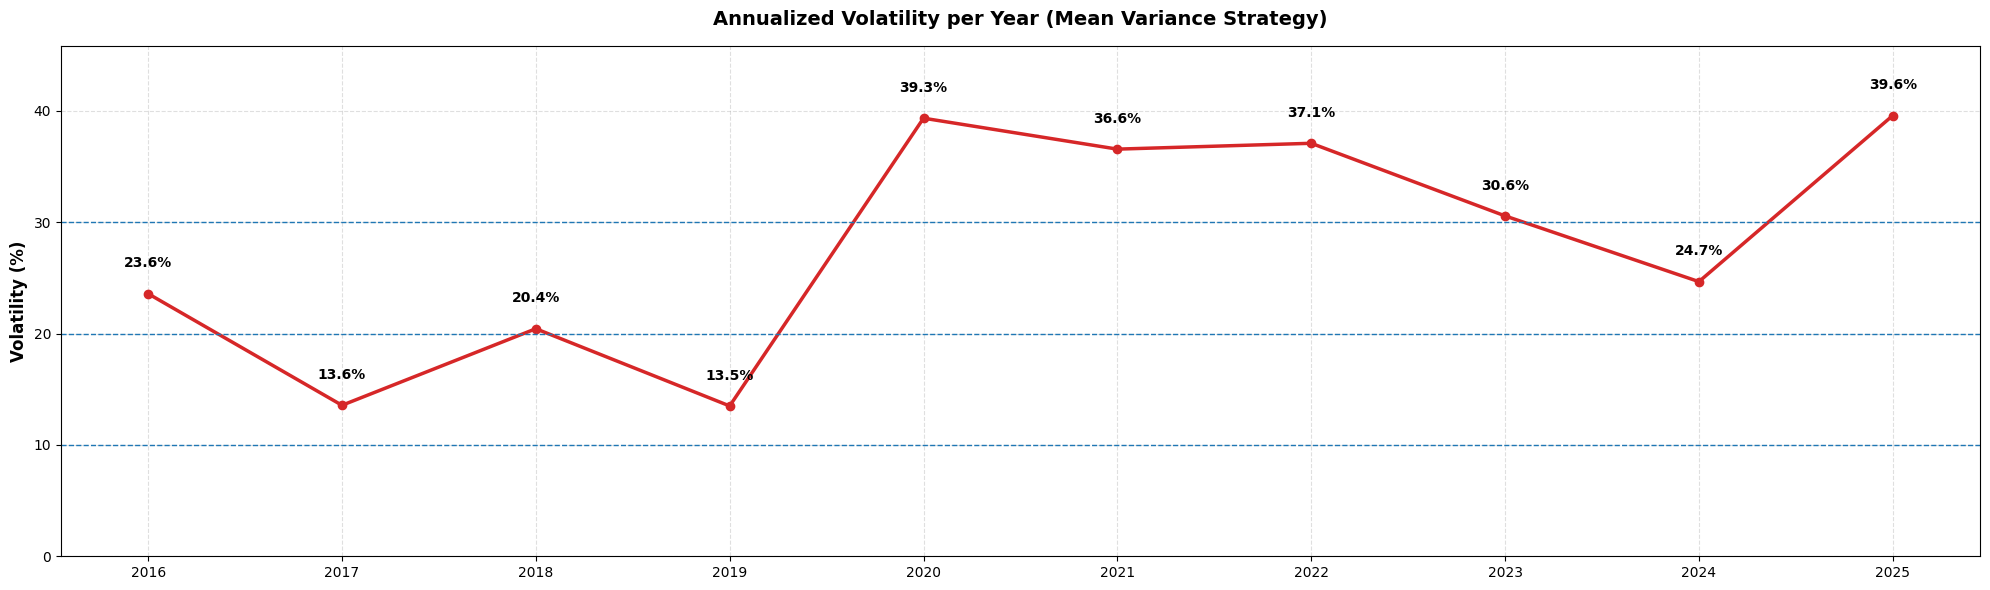

In [ ]:
values = yearly_ann_vol["MeanVariance"] * 100

plt.figure(figsize=(20, 6), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#d62728')

y_range = values.max() - values.min()
offset = y_range * 0.08 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x, y + offset, f"{y:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Annualized Volatility per Year (Mean Variance Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Volatility (%)", fontsize=12, fontweight="bold")

for y in [10, 20, 30]:
    plt.axhline(y, linewidth=1, linestyle="--")

plt.xticks(years)
plt.ylim(0, values.max() + offset * 3)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## **Annualized Sharpe Ratio**

0 = Break even

1 = Good

2 = Very Good

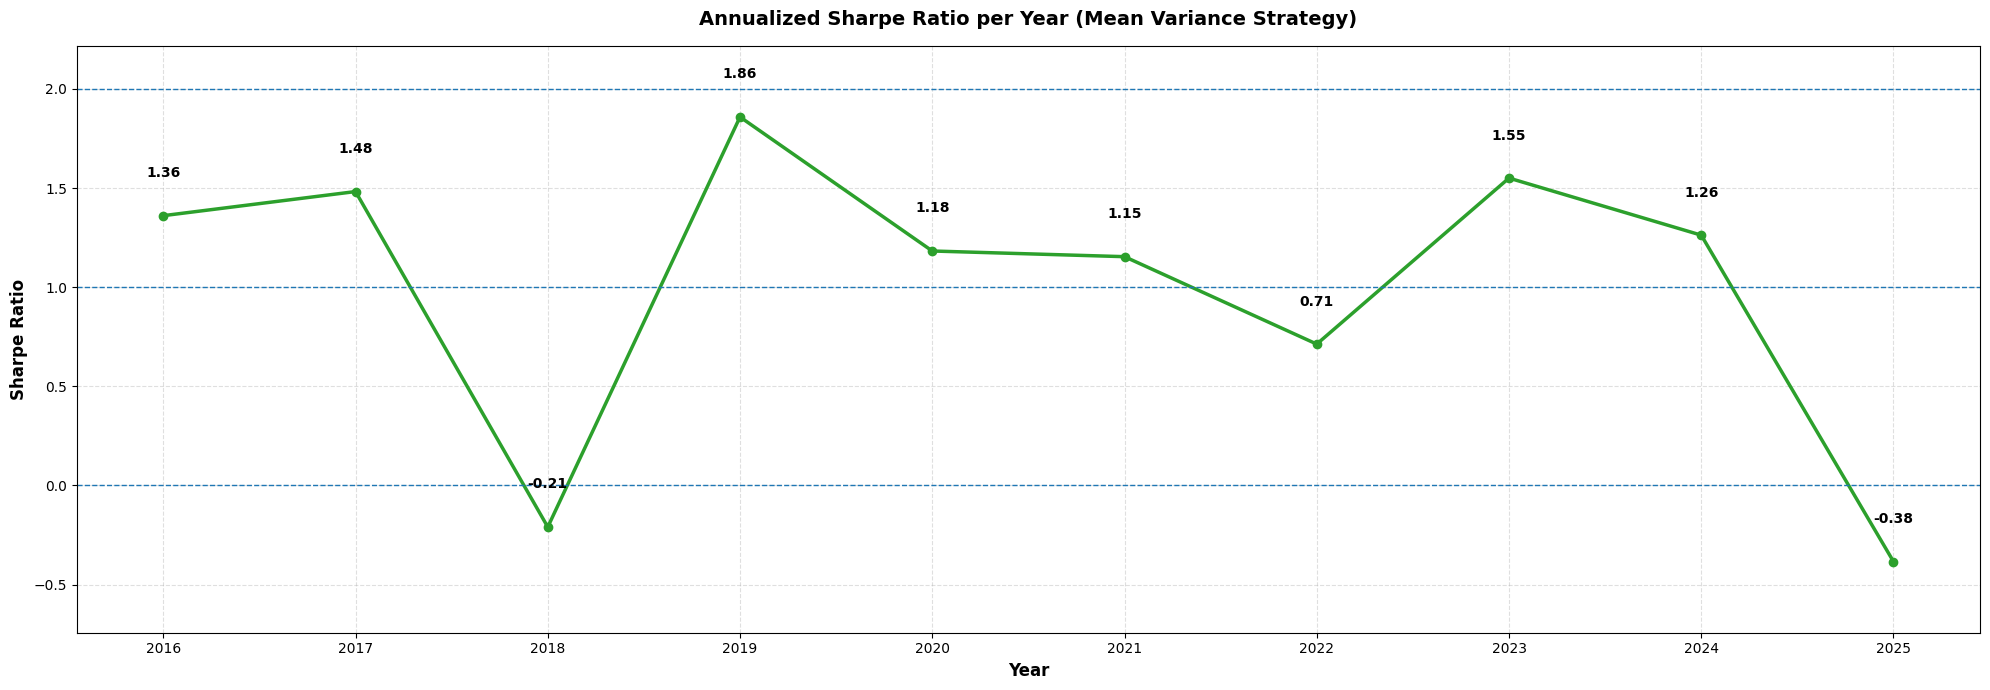

In [ ]:
values = yearly_ann_sharpe["MeanVariance"]
plt.figure(figsize=(20, 7), facecolor="white")
plt.plot(years, values, marker="o", linewidth=2.5, color='#2ca02c')
y_range = values.max() - values.min()
offset = y_range * 0.08 if y_range != 0 else 0.1

for x, y in zip(years, values):
    plt.text(x, y + offset, f"{y:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Annualized Sharpe Ratio per Year (Mean Variance Strategy)", fontsize=14, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Sharpe Ratio", fontsize=12, fontweight="bold")

for y in [-1, 0, 1, 2]:
    plt.axhline(y, linewidth=1, linestyle="--")

plt.xticks(years)
plt.ylim(values.min() - offset * 2, values.max() + offset * 2)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# **Portfolio Allocation 2026**

In [ ]:
# last_features = X_raw.tail(LOOKBACK_WINDOW)
# mean_recent = X_raw.tail(ROLLING_SCALER_DAYS).mean()
# std_recent = X_raw.tail(ROLLING_SCALER_DAYS).std()
# last_features_scaled = (last_features - mean_recent) / (std_recent + 1e-8)
# input_dl = last_features_scaled.values.reshape(1, LOOKBACK_WINDOW, -1)

# dl_weights = model.predict(input_dl, verbose=0)[0]
# dl_weights = np.clip(dl_weights, 0, 1)
# dl_weights /= dl_weights.sum()

# recent_asset_returns = y_raw.tail(252)
# mu_assets = recent_asset_returns.mean() * 252
# sigma_assets = recent_asset_returns.cov() * 252

# def neg_sharpe(w):
#     r = np.dot(mu_assets, w)
#     v = np.sqrt(w.T @ sigma_assets @ w) + 1e-8
#     return -r / v

# constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
# bounds = tuple((0, 1) for _ in range(len(TICKERS)))
# init_w = np.ones(len(TICKERS)) / len(TICKERS)

# mvo_weights = minimize(neg_sharpe, init_w, method='SLSQP', bounds=bounds, constraints=constraints).x

# labels = [t.replace('.JK', '') for t in TICKERS]
# colors = ['#80b3ff', '#ffcc80', '#8aff80', '#ff8080']
# explode = [0.05]*len(TICKERS)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), facecolor="white")

# def make_autopct(pct):
#     return f'{pct:.1f}%'

# ax1.pie(dl_weights, labels=labels, autopct=lambda pct: f'{pct:.1f}%', startangle=140, colors=colors, explode=explode, wedgeprops={'edgecolor': 'white', 'linewidth': 2}, textprops={'weight': 'bold'})
# ax1.set_title("Portfolio Allocation 2026 (Deep Learning Model Strategy)", fontsize=14, fontweight='bold')

# ax2.pie(mvo_weights, labels=labels, autopct=lambda pct: f'{pct:.1f}%', startangle=140,colors=colors, explode=explode, wedgeprops={'edgecolor': 'white', 'linewidth': 2}, textprops={'weight': 'bold'})
# ax2.set_title("Portfolio Allocation 2026 (Mean Variance Strategy)", fontsize=14, fontweight='bold')

# plt.tight_layout()
# plt.show()

# **Annual Portfolio Return Expectations**

In [ ]:
# expected_return_dl = np.dot(dl_weights, mu_assets)
# expected_return_mvo = np.dot(mvo_weights, mu_assets)

# models = ['Deep Learning Model Strategy', 'Mean Variance Strategy']
# returns = [expected_return_dl * 100, expected_return_mvo * 100]

# plt.figure(figsize=(10, 6), facecolor="white")
# bars = plt.bar(models, returns, color=['#1f77b4', '#2ca02c'], alpha=0.8)
# plt.title("Annual Portfolio Return Expectations (2026)", fontsize=14, fontweight='bold')
# plt.ylabel("Return (%)", fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.6)

# for bar, ret in zip(bars, returns):
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1,f'{ret:.2f}%', ha='center', va='bottom', fontweight='bold')

# plt.xticks(fontweight='bold')
# plt.tight_layout()
# plt.show()

# **Three Dimensional Analysis of Threshold Conditions for Positive Expected Value**

In [ ]:
p = np.linspace(0.05, 0.95, 100)
l = np.linspace(0, 100, 100)
P, L = np.meshgrid(p, l)
R = (L * (1 - P)) / P
R_clipped = np.clip(R, 0, 200)

fig = go.Figure(data=[go.Surface(x=P,y=L,z=R_clipped,colorscale='Viridis',
    colorbar=dict(title='Min Required Return (R)'),
    hovertemplate='Prob of Win (p): %{x:.2f}<br>Avg Expected Loss (L): %{y:.2f}%<br>Min Required Return (R): %{z:.2f}%<extra></extra>'
)])

fig.update_layout(title='Three-Dimensional Analysis of Threshold Conditions for Positive Expected Value',
    scene=dict(
        xaxis_title='Probability of Win (p)',
        yaxis_title='Average Expected Loss % (L)',
        zaxis_title='Min Required Return (R)',
        xaxis=dict(nticks=10, range=[0, 1], backgroundcolor="rgb(230, 230,230)"),
        yaxis=dict(nticks=10, range=[0, 100], backgroundcolor="rgb(230, 230,230)"),
        zaxis=dict(nticks=10, range=[0, 200], backgroundcolor="rgb(230, 230,230)"),
        aspectratio=dict(x=1, y=1, z=0.8),
        camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))
    ),
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()

# **3D Portfolio Analysis: Return vs Risk vs Efficiency**

In [ ]:
def generate_professional_3d_plot(results_df):
    plot_data = []
    for col in results_df.columns:
        total_ret = results_df[col].iloc[-1] / results_df[col].iloc[0] - 1
        days = (results_df[col].index[-1] - results_df[col].index[0]).days
        ann_ret = ((1 + total_ret) ** (365 / max(days, 1)) - 1) * 100

        peak = results_df[col].cummax()
        dd = (results_df[col] - peak) / peak
        mdd = abs(dd.min() * 100)

        daily_rets = results_df[col].pct_change().dropna()
        sharpe = (daily_rets.mean() / (daily_rets.std() + 1e-6)) * np.sqrt(252)

        plot_data.append({'Strategy': col, 'Return': ann_ret, 'Drawdown': mdd, 'Sharpe': sharpe})

    df_metrics = pd.DataFrame(plot_data)
    fig = go.Figure()

    colors = {'Model': '#1f77b4', 'EqualWeight': '#7f7f7f', 'MeanVariance': '#ff7f0e'}

    for _, row in df_metrics.iterrows():
        fig.add_trace(go.Scatter3d(
            x=[row['Return']],
            y=[row['Drawdown']],
            z=[row['Sharpe']],
            mode='markers+text',
            marker=dict(
                size=20,
                color=row['Sharpe'],
                colorscale='Plasma',
                opacity=0.95,
                line=dict(color='black', width=2)
            ),
            text=[f"{row['Strategy']}<br>Return: {row['Return']:.2f}%<br>MDD: {row['Drawdown']:.2f}%<br>Sharpe: {row['Sharpe']:.2f}"],
            textposition="top center",
            hoverinfo='text'
        ))

    x_range = np.linspace(df_metrics['Return'].min() * 0.8, df_metrics['Return'].max() * 1.2, 50)
    y_range = np.linspace(df_metrics['Drawdown'].min() * 0.8, df_metrics['Drawdown'].max() * 1.2, 50)
    X, Y = np.meshgrid(x_range, y_range)
    Z = (X / (Y + 1e-9)) * (df_metrics['Sharpe'].mean() / (df_metrics['Return'].mean() / df_metrics['Drawdown'].mean()))

    fig.add_trace(go.Surface(x=X,y=Y,z=Z,colorscale='Viridis',opacity=0.25,showscale=True,
        colorbar=dict(title="Sharpe Ratio", x=1.1),
        contours=dict(z=dict(show=True, usecolormap=True, highlightcolor="white", project_z=True))
    ))

    fig.update_layout(
        title=dict(text='3D Portfolio Analysis: Return, Risk & Efficiency',font=dict(size=20, color='#2c3e50'),x=0.5),
        scene=dict(
            xaxis_title='Annual Return (%)',
            yaxis_title='Max Drawdown (%)',
            zaxis_title='Sharpe Ratio',
            xaxis=dict(backgroundcolor="#d0d0d0", gridcolor="white", showbackground=True),
            yaxis=dict(backgroundcolor="#d0d0d0", gridcolor="white", showbackground=True),
            zaxis=dict(backgroundcolor="#d0d0d0", gridcolor="white", showbackground=True)
        ),
        width=1100,
        height=850,
        margin=dict(l=0, r=0, b=0, t=60),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
    )

    fig.update_layout(scene_camera=dict(eye=dict(x=2, y=2, z=1.3)))
    fig.show()

generate_professional_3d_plot(results_df)